# Bài tập cuối kỳ môn Machine Learning: Dự đoán xem một nhân viên sẽ nghỉ việc hay không
- Đồ án được hoàn thành bởi
    - La Nguyễn Quốc Thịnh - 521H0513
    - Trần Quốc Bảo - 521H0494
    - Nguyễn Văn Khoa - 521H0251


## Thư viện

In [141]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.model_selection import GridSearchCV

import tensorflow as tf
from tensorflow import keras
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout

## Define các hàm để in ra sự so sánh (nếu có)

In [587]:
title_1 = "Non-hyperparameter"
title_2 = "Hyperparameter"

def visualize_metrics(metrics):

    # List of classifiers and metrics
    classifiers = list(metrics.keys())
    metric_names = list(metrics[classifiers[0]].keys())


    bar_width = 0.15  # Set the width of the bars
    padding = 0.05  # Adjust the padding value as desired

    # Set the positions of the x-axis ticks
    x_pos = np.arange(len(classifiers))

    fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the bar chart size

    # Plot each metric as a group of bars
    for i, metric in enumerate(metric_names):
        metric_values = [metrics[classifier][metric] for classifier in classifiers]
        bar_positions = x_pos + ((bar_width + padding) * i)
        ax.bar(bar_positions, metric_values, bar_width, label=metric)

    # Set the labels and title
    ax.set_xlabel('Classifier')
    ax.set_ylabel('Score')
    ax.set_title('Comparison of Metrics')
    ax.set_xticks(x_pos + (((bar_width + padding) * (len(metric_names) - 1)) / 2))
    ax.set_xticklabels(classifiers)
    ax.legend(bbox_to_anchor=(1.04, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

def compare_metrics(training_metrics, testing_metrics):
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']

    x = np.arange(len(metrics))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    training_bars = ax.bar(x - width/2, training_metrics, width, label='Training Set', color='skyblue')
    testing_bars = ax.bar(x + width/2, testing_metrics, width, label='Testing Set', color='lightgreen')

    ax.set_ylabel('Metrics', fontsize=14)
    ax.set_title('Metrics Comparison', fontsize=16, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics, fontsize=12)
    ax.legend(fontsize=12)

    for bar in training_bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                    textcoords="offset points", ha='center', va='bottom', fontsize=11)

    for bar in testing_bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                    textcoords="offset points", ha='center', va='bottom', fontsize=11)

    plt.ylim(0, 1.1)
    plt.yticks(fontsize=11)
    plt.grid(axis='y', linestyle='--')

    fig.tight_layout()
    plt.show()
    
def compare_metrics(training_metrics, testing_metrics, title):
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']

    x = np.arange(len(metrics))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    training_bars = ax.bar(x - width/2, training_metrics, width, label='Training Set', color='skyblue')
    testing_bars = ax.bar(x + width/2, testing_metrics, width, label='Testing Set', color='lightgreen')

    ax.set_ylabel('Metrics', fontsize=14)
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics, fontsize=12)
    ax.legend(fontsize=12)

    for bar in training_bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                    textcoords="offset points", ha='center', va='bottom', fontsize=11)

    for bar in testing_bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                    textcoords="offset points", ha='center', va='bottom', fontsize=11)

    plt.ylim(0, 1.1)
    plt.yticks(fontsize=11)
    plt.grid(axis='y', linestyle='--')

    fig.tight_layout()
    plt.show()
    
    
def compute_metric_difference(train_metrics, test_metrics):
    """
    Tính toán độ chênh lệch giữa các giá trị metrics trên tập huấn luyện và tập kiểm tra.

    Arguments:
    train_metrics (list): Danh sách chứa các giá trị metrics trên tập huấn luyện.
    test_metrics (list): Danh sách chứa các giá trị metrics trên tập kiểm tra.
    """

    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

    print("Độ chêch lệch giữa các giá trị metrics trên tập huấn luyện và tập kiểm tra: ")
    for i, metric_name in enumerate(metrics):
        train_value = train_metrics[i]
        test_value = test_metrics[i]
        difference = round(train_value - test_value, 4)
        print(f"{metric_name}: {difference}")    


def print_metrics(accuracy, precision, recall, f1):
        print("Accuracy: {:.4f}".format(accuracy))
        print("Precision: {:.4f}".format(precision))
        print("Recall: {:.4f}".format(recall))
        print("F1-Score: {:.4f}".format(f1))

def plot_loss_history(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_accuracy_history(history):
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def plot_accuracy_history_comparision(history_before, history_after):
    plt.figure(figsize=(12, 5))

    # Plot for history_before
    plt.subplot(1, 2, 1)
    plt.plot(history_before.history['accuracy'], label='Training Accuracy (Before)')
    plt.plot(history_before.history['val_accuracy'], label='Validation Accuracy (Before)')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy History Before')

    # Plot for history_after
    plt.subplot(1, 2, 2)
    plt.plot(history_after.history['accuracy'], label='Training Accuracy (After)')
    plt.plot(history_after.history['val_accuracy'], label='Validation Accuracy (After)')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy History After')

    # Adjust layout
    plt.tight_layout()

    plt.show()
    
def plot_loss_history_comparision(history_before, history_after):
    plt.figure(figsize=(12, 5))

    # Plot for history_before
    plt.subplot(1, 2, 1)
    plt.plot(history_before.history['loss'], label='Training Loss (Before)')
    plt.plot(history_before.history['val_loss'], label='Validation Loss (Before)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss History Before')

    # Plot for history_after
    plt.subplot(1, 2, 2)
    plt.plot(history_after.history['loss'], label='Training Loss (After)')
    plt.plot(history_after.history['val_loss'], label='Validation Loss (After)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss History After')

    # Adjust layout
    plt.tight_layout()

    plt.show()



## Phần 1: Data Preprocessing + Data Exploration

### Data cleaning

In [143]:
df = pd.DataFrame(pd.read_csv('Employee.csv'))
df

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
1,Bachelors,2013,Pune,1,28,Female,No,3,1
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0
3,Masters,2016,Bangalore,3,27,Male,No,5,1
4,Masters,2017,Pune,3,24,Male,Yes,2,1
...,...,...,...,...,...,...,...,...,...
4648,Bachelors,2013,Bangalore,3,26,Female,No,4,0
4649,Masters,2013,Pune,2,37,Male,No,2,1
4650,Masters,2018,New Delhi,3,27,Male,No,5,1
4651,Bachelors,2012,Bangalore,3,30,Male,Yes,2,0


In [144]:
df.isna().sum()

# Không có giá trị null trong tập dữ liệu nên không cần xử lý "Missing Values"

Education                    0
JoiningYear                  0
City                         0
PaymentTier                  0
Age                          0
Gender                       0
EverBenched                  0
ExperienceInCurrentDomain    0
LeaveOrNot                   0
dtype: int64

In [145]:
df.duplicated().sum()
df.drop_duplicates(inplace=True)

# Xử lý dữ liệu trùng lặp.

### Data handling Categorical và Transformation


In [146]:
df['Education'].unique()


array(['Bachelors', 'Masters', 'PHD'], dtype=object)

In [147]:
df['City'].unique()

array(['Bangalore', 'Pune', 'New Delhi'], dtype=object)

In [148]:
df['PaymentTier'].unique()

array([3, 1, 2], dtype=int64)

In [149]:
# Có 3 features thuộc dạng categorical nên cần phải chuyển đổi

df_dummies = pd.get_dummies(df, columns=['JoiningYear', 'Education', 'City', 'PaymentTier', 'EverBenched', 'Gender'])
df_dummies

,Age,ExperienceInCurrentDomain,LeaveOrNot,JoiningYear_2012,JoiningYear_2013,JoiningYear_2014,JoiningYear_2015,JoiningYear_2016,JoiningYear_2017,JoiningYear_2018,...,City_Bangalore,City_New Delhi,City_Pune,PaymentTier_1,PaymentTier_2,PaymentTier_3,EverBenched_No,EverBenched_Yes,Gender_Female,Gender_Male
0,34,0,0,False,False,False,False,False,True,False,...,True,False,False,False,False,True,True,False,False,True
1,28,3,1,False,True,False,False,False,False,False,...,False,False,True,True,False,False,True,False,True,False
2,38,2,0,False,False,True,False,False,False,False,...,False,True,False,False,False,True,True,False,True,False
3,27,5,1,False,False,False,False,True,False,False,...,True,False,False,False,False,True,True,False,False,True
4,24,2,1,False,False,False,False,False,True,False,...,False,False,True,False,False,True,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4645,31,2,0,False,False,False,False,False,True,False,...,False,False,True,False,True,False,True,False,True,False
4647,30,2,0,False,False,False,False,True,False,False,...,False,False,True,False,False,True,True,False,False,True
4649,37,2,1,False,True,False,False,False,False,False,...,False,False,True,False,True,False,True,False,False,True
4650,27,5,1,False,False,False,False,False,False,True,...,False,True,False,False,False,True,True,False,False,True


In [150]:
df_dummies.dtypes

Age                          int64
ExperienceInCurrentDomain    int64
LeaveOrNot                   int64
JoiningYear_2012              bool
JoiningYear_2013              bool
JoiningYear_2014              bool
JoiningYear_2015              bool
JoiningYear_2016              bool
JoiningYear_2017              bool
JoiningYear_2018              bool
Education_Bachelors           bool
Education_Masters             bool
Education_PHD                 bool
City_Bangalore                bool
City_New Delhi                bool
City_Pune                     bool
PaymentTier_1                 bool
PaymentTier_2                 bool
PaymentTier_3                 bool
EverBenched_No                bool
EverBenched_Yes               bool
Gender_Female                 bool
Gender_Male                   bool
dtype: object

In [151]:
le = LabelEncoder()

name = list(df_dummies.columns)
type = df_dummies.dtypes

for i in range(len(type)):
    if type[i] == 'object':
        le.fit_transform(df_dummies[name[i]])
        df_dummies[name[i]] = le.transform(df_dummies[name[i]])

df_dummies

C:\Users\Thinh\AppData\Local\Temp\ipykernel_18388\3446361408.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if type[i] == 'object':


,Age,ExperienceInCurrentDomain,LeaveOrNot,JoiningYear_2012,JoiningYear_2013,JoiningYear_2014,JoiningYear_2015,JoiningYear_2016,JoiningYear_2017,JoiningYear_2018,...,City_Bangalore,City_New Delhi,City_Pune,PaymentTier_1,PaymentTier_2,PaymentTier_3,EverBenched_No,EverBenched_Yes,Gender_Female,Gender_Male
0,34,0,0,False,False,False,False,False,True,False,...,True,False,False,False,False,True,True,False,False,True
1,28,3,1,False,True,False,False,False,False,False,...,False,False,True,True,False,False,True,False,True,False
2,38,2,0,False,False,True,False,False,False,False,...,False,True,False,False,False,True,True,False,True,False
3,27,5,1,False,False,False,False,True,False,False,...,True,False,False,False,False,True,True,False,False,True
4,24,2,1,False,False,False,False,False,True,False,...,False,False,True,False,False,True,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4645,31,2,0,False,False,False,False,False,True,False,...,False,False,True,False,True,False,True,False,True,False
4647,30,2,0,False,False,False,False,True,False,False,...,False,False,True,False,False,True,True,False,False,True
4649,37,2,1,False,True,False,False,False,False,False,...,False,False,True,False,True,False,True,False,False,True
4650,27,5,1,False,False,False,False,False,False,True,...,False,True,False,False,False,True,True,False,False,True


### Data Exploration

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'ExperienceInCurrentDomain'}>],
       [<Axes: title={'center': 'LeaveOrNot'}>, <Axes: >]], dtype=object)

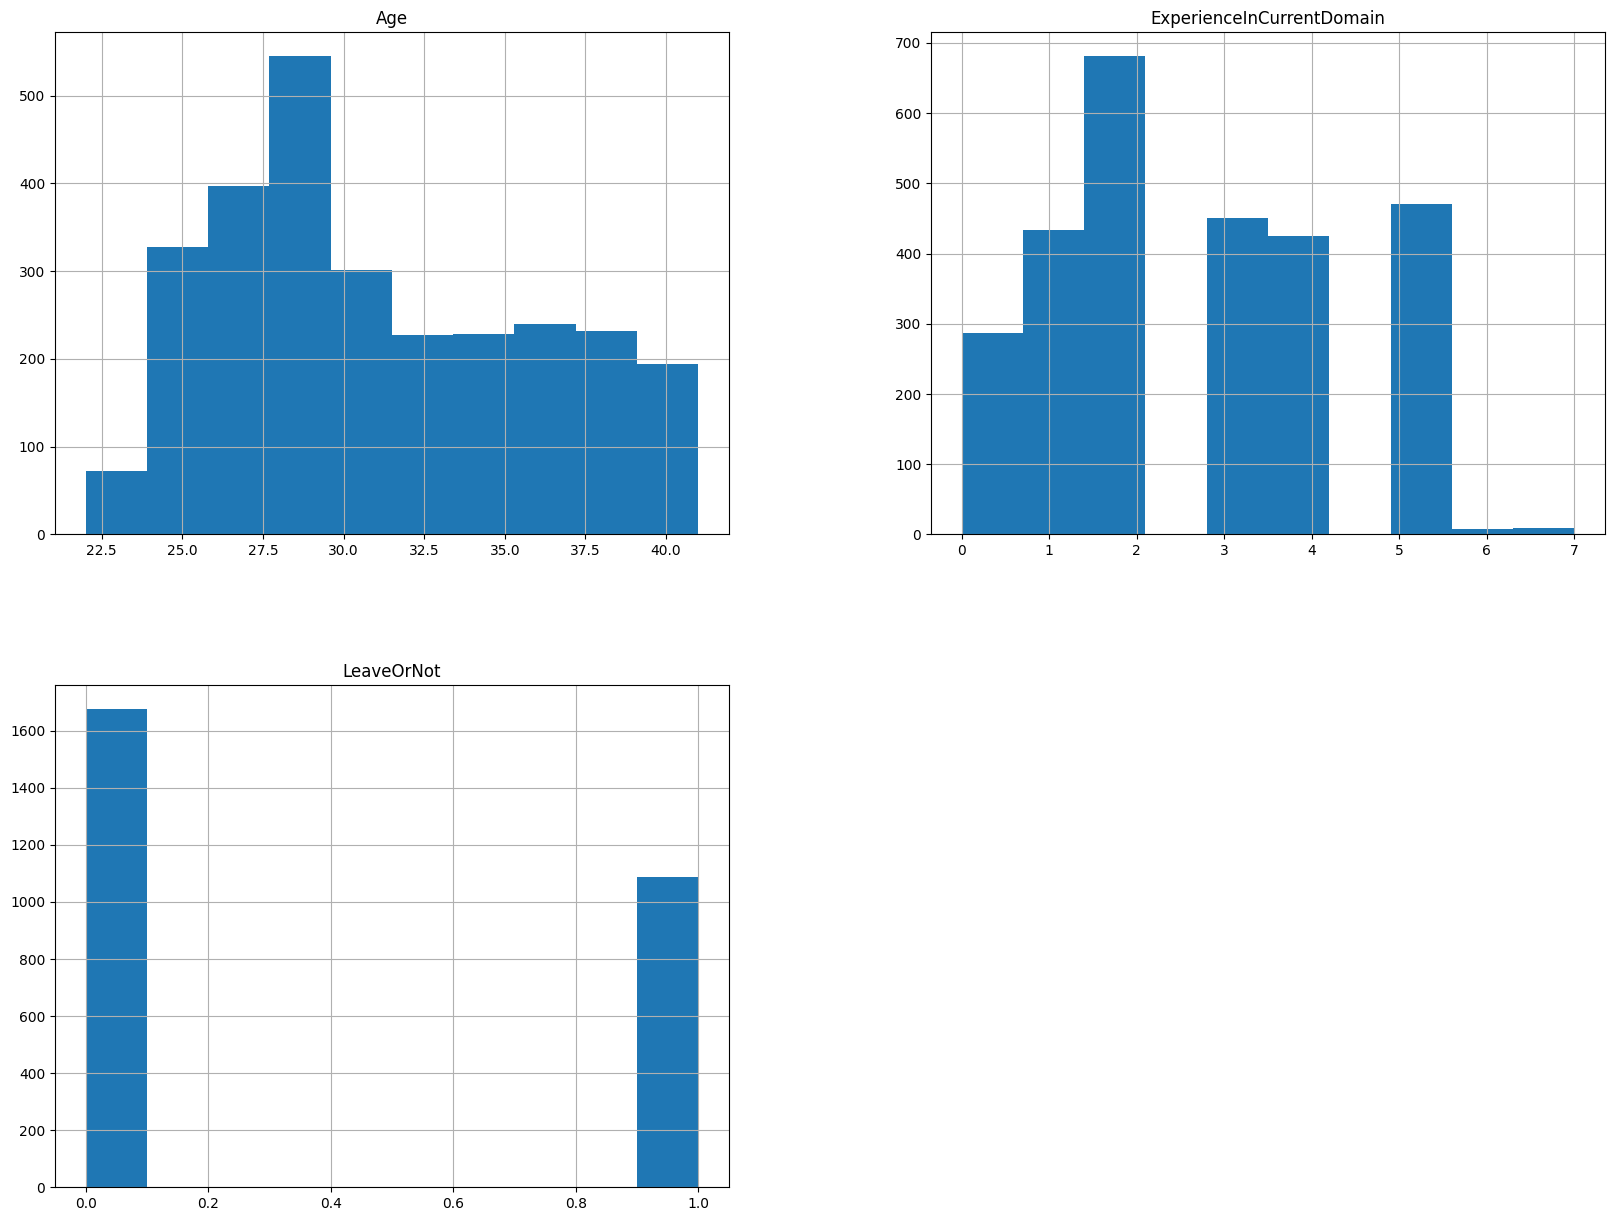

In [152]:
df_dummies.hist(figsize=(20, 15))

C:\Users\Thinh\AppData\Local\Temp\ipykernel_18388\385756184.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msg['p_count']=np.round(msg['count']/msg['count'].sum(), 2)
C:\Users\Thinh\AppData\Local\Temp\ipykernel_18388\385756184.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msg['p_count']=np.round(msg['count']/msg['count'].sum(), 2)
C:\Users\Thinh\AppData\Local\Temp\ipykernel_18388\385756184.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

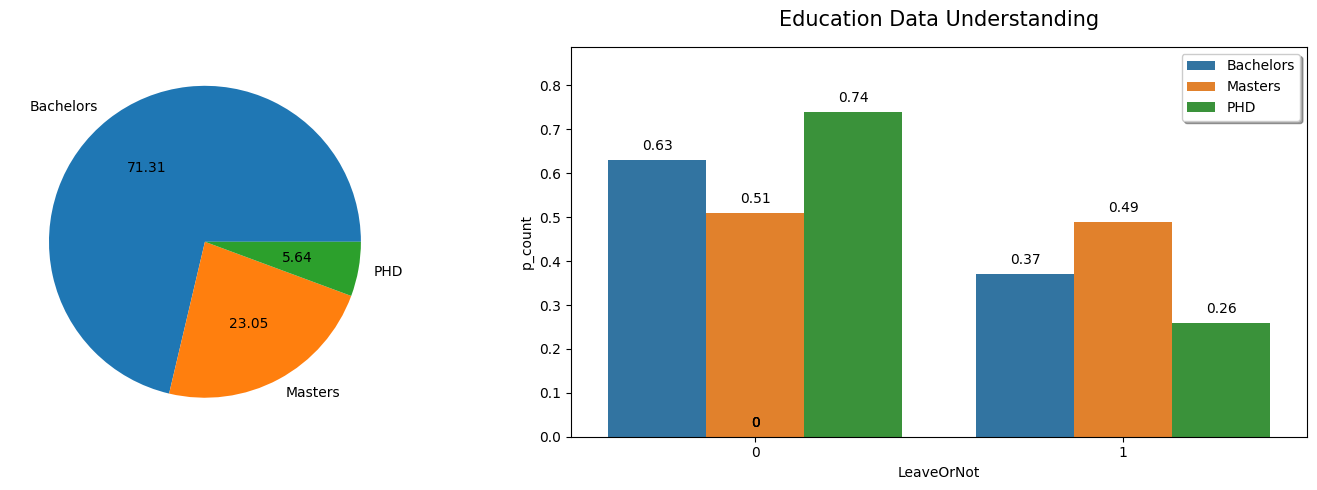

In [153]:
# xem tỉ lê số lượng nhân viên bỏ việc dựa trên trình độ học vấn

data1=df.Education.value_counts().reset_index()
data2=df.groupby(['Education','LeaveOrNot']).size().reset_index().rename(columns={0:'count'})
data2_=[]
for x in data2.Education.unique():
    msg=data2[data2.Education==x]
    msg['p_count']=np.round(msg['count']/msg['count'].sum(), 2)
    data2_.append(msg)
data2=pd.concat(data2_)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].pie(data1['count'], labels=data1['Education'], autopct='%.2f')
ax[1].set_title('Education Data Understanding', fontsize=15, pad=15)

# Bar plot
bar_plot = sns.barplot(data=data2, x='LeaveOrNot', y='p_count', hue='Education', ax=ax[1])

# Show the annotate on the top of barplot
for p in bar_plot.patches:
    bar_plot.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='center', xytext=(0, 10), textcoords='offset points')

ax[1].legend(shadow=True)
ax[1].set_ylim(ymin=0, ymax=data2['p_count'].max() + (data2['p_count'].max()*0.2))

plt.tight_layout()
plt.show()

C:\Users\Thinh\AppData\Local\Temp\ipykernel_18388\3541328264.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msg['p_count']=np.round(msg['count']/msg['count'].sum(), 2)
C:\Users\Thinh\AppData\Local\Temp\ipykernel_18388\3541328264.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msg['p_count']=np.round(msg['count']/msg['count'].sum(), 2)
C:\Users\Thinh\AppData\Local\Temp\ipykernel_18388\3541328264.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

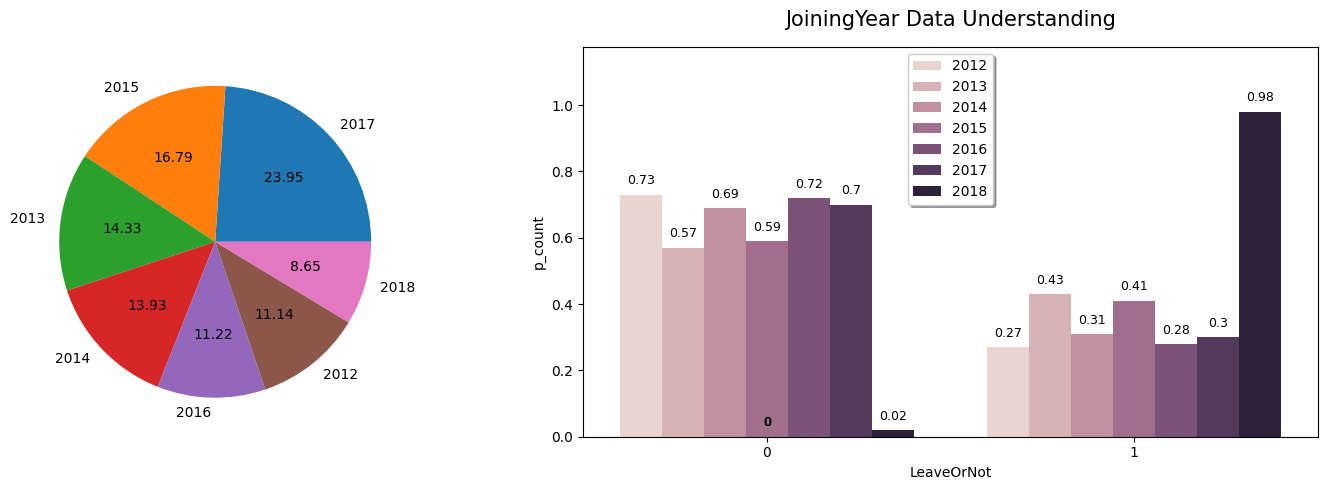

In [154]:
# xem tỉ lê số lượng nhân viên bỏ việc dựa trên năm ứng tuyển

data1=df.JoiningYear.value_counts().reset_index()
data2=df.groupby(['JoiningYear','LeaveOrNot']).size().reset_index().rename(columns={0:'count'})
data2_=[]
for x in data2.JoiningYear.unique():
    msg=data2[data2.JoiningYear==x]
    msg['p_count']=np.round(msg['count']/msg['count'].sum(), 2)
    data2_.append(msg)
data2=pd.concat(data2_)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].pie(data1['count'], labels=data1['JoiningYear'], autopct='%.2f')
ax[1].set_title('JoiningYear Data Understanding', fontsize=15, pad=15)

# Bar plot
bar_plot = sns.barplot(data=data2, x='LeaveOrNot', y='p_count', hue='JoiningYear', ax=ax[1])

# Show the annotate on the top of barplot
for p in bar_plot.patches:
    bar_plot.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=9)

ax[1].legend(shadow=True)
ax[1].set_ylim(ymin=0, ymax=data2['p_count'].max() + (data2['p_count'].max()*0.2))

plt.tight_layout()
plt.show()

C:\Users\Thinh\AppData\Local\Temp\ipykernel_18388\628811176.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msg['p_count']=np.round(msg['count']/msg['count'].sum(), 2)
C:\Users\Thinh\AppData\Local\Temp\ipykernel_18388\628811176.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msg['p_count']=np.round(msg['count']/msg['count'].sum(), 2)
C:\Users\Thinh\AppData\Local\Temp\ipykernel_18388\628811176.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

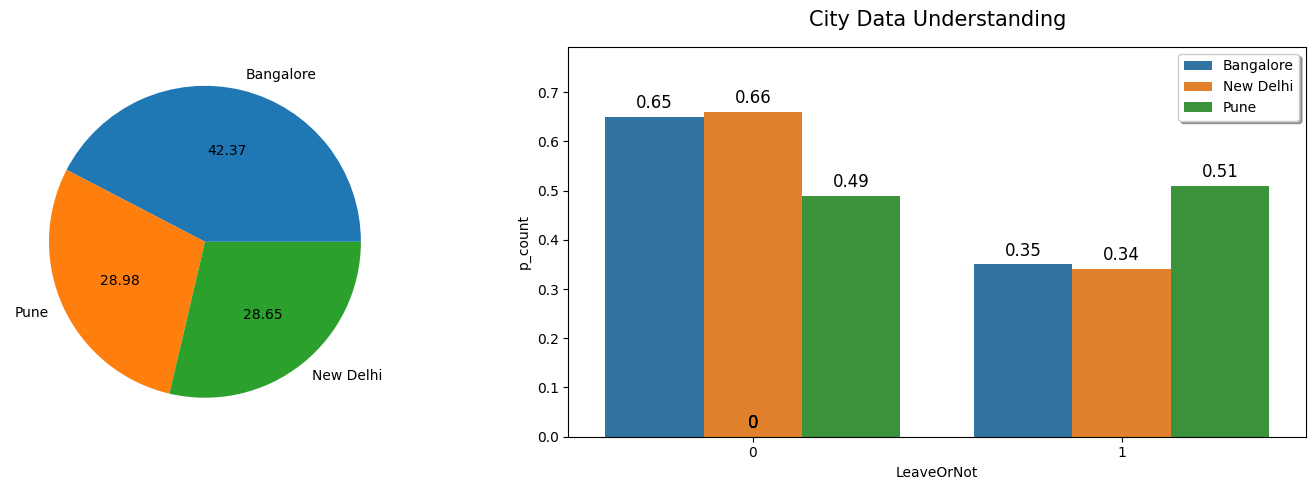

In [155]:
# xem tỉ lê số lượng nhân viên bỏ việc dựa trên thành phố sinh sống

data1=df.City.value_counts().reset_index()
data2=df.groupby(['City','LeaveOrNot']).size().reset_index().rename(columns={0:'count'})
data2_=[]
for x in data2.City.unique():
    msg=data2[data2.City==x]
    msg['p_count']=np.round(msg['count']/msg['count'].sum(), 2)
    data2_.append(msg)
data2=pd.concat(data2_)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].pie(data1['count'], labels=data1['City'], autopct='%.2f')
ax[1].set_title('City Data Understanding', fontsize=15, pad=15)

# Bar plot
bar_plot = sns.barplot(data=data2, x='LeaveOrNot', y='p_count', hue='City', ax=ax[1])

# Show the annotate on the top of barplot
for p in bar_plot.patches:
    bar_plot.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=12)

ax[1].legend(shadow=True)
ax[1].set_ylim(ymin=0, ymax=data2['p_count'].max() + (data2['p_count'].max()*0.2))

plt.tight_layout()
plt.show()

C:\Users\Thinh\AppData\Local\Temp\ipykernel_18388\1634165482.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msg['p_count']=np.round(msg['count']/msg['count'].sum(), 2)
C:\Users\Thinh\AppData\Local\Temp\ipykernel_18388\1634165482.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msg['p_count']=np.round(msg['count']/msg['count'].sum(), 2)


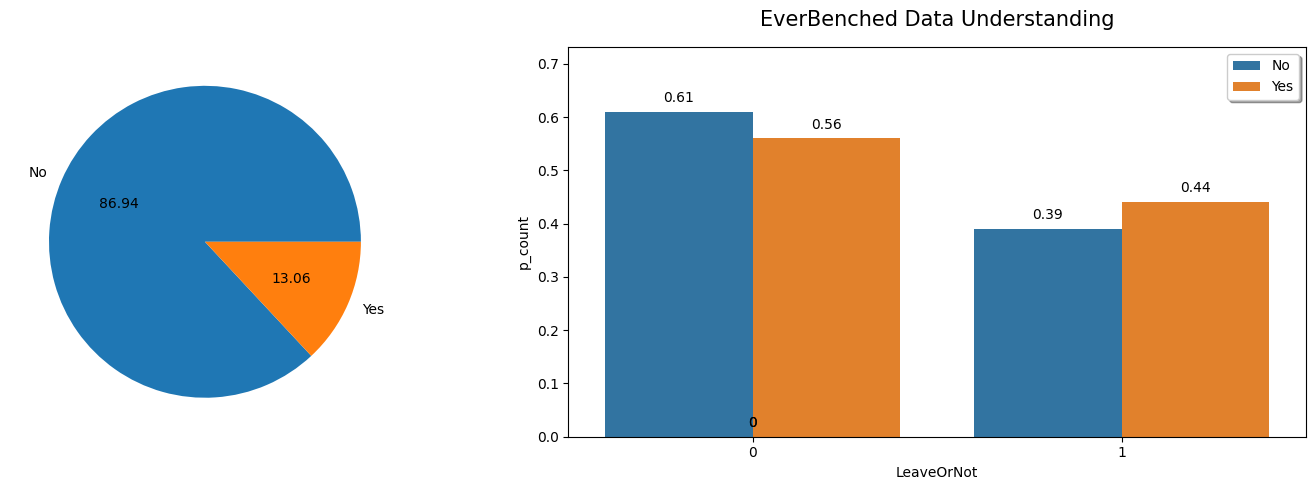

In [156]:
# xem tỉ lê số lượng nhân viên bỏ việc dựa trên lịch sử thăng cấp

data1=df.EverBenched.value_counts().reset_index()
data2=df.groupby(['EverBenched','LeaveOrNot']).size().reset_index().rename(columns={0:'count'})
data2_=[]
for x in data2.EverBenched.unique():
    msg=data2[data2.EverBenched==x]
    msg['p_count']=np.round(msg['count']/msg['count'].sum(), 2)
    data2_.append(msg)
data2=pd.concat(data2_)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].pie(data1['count'], labels=data1['EverBenched'], autopct='%.2f')
ax[1].set_title('EverBenched Data Understanding', fontsize=15, pad=15)

# Bar plot
bar_plot = sns.barplot(data=data2, x='LeaveOrNot', y='p_count', hue='EverBenched', ax=ax[1])

# Show the annotate on the top of barplot
for p in bar_plot.patches:
    bar_plot.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='center', xytext=(0, 10), textcoords='offset points')

ax[1].legend(shadow=True)
ax[1].set_ylim(ymin=0, ymax=data2['p_count'].max() + (data2['p_count'].max()*0.2))

plt.tight_layout()
plt.show()

C:\Users\Thinh\AppData\Local\Temp\ipykernel_18388\268465423.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msg['p_count']=np.round(msg['count']/msg['count'].sum(), 2)
C:\Users\Thinh\AppData\Local\Temp\ipykernel_18388\268465423.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msg['p_count']=np.round(msg['count']/msg['count'].sum(), 2)


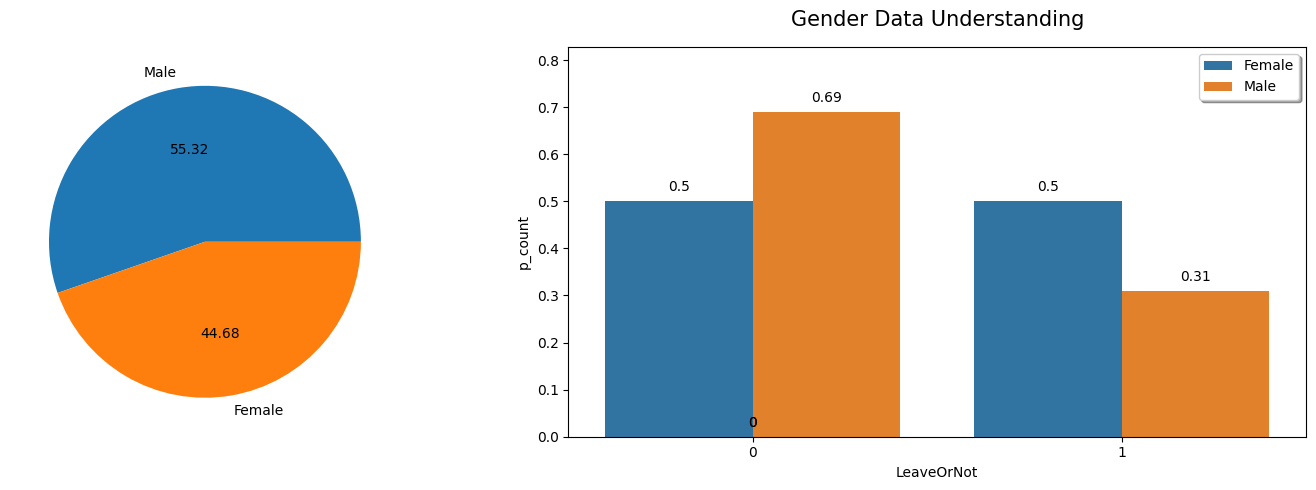

In [157]:
# xem tỉ lê số lượng nhân viên bỏ việc dựa trên giới tính

data1=df.Gender.value_counts().reset_index()
data2=df.groupby(['Gender','LeaveOrNot']).size().reset_index().rename(columns={0:'count'})
data2_=[]
for x in data2.Gender.unique():
    msg=data2[data2.Gender==x]
    msg['p_count']=np.round(msg['count']/msg['count'].sum(), 2)
    data2_.append(msg)
data2=pd.concat(data2_)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].pie(data1['count'], labels=data1['Gender'], autopct='%.2f')
ax[1].set_title('Gender Data Understanding', fontsize=15, pad=15)

# Bar plot
bar_plot = sns.barplot(data=data2, x='LeaveOrNot', y='p_count', hue='Gender', ax=ax[1])

# Show the annotate on the top of barplot
for p in bar_plot.patches:
    bar_plot.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='center', xytext=(0, 10), textcoords='offset points')

ax[1].legend(shadow=True)
ax[1].set_ylim(ymin=0, ymax=data2['p_count'].max() + (data2['p_count'].max()*0.2))

plt.tight_layout()
plt.show()

### Sử dụng Pearson Corelation để xem điểm tương quang giữa các Feature

<Axes: >

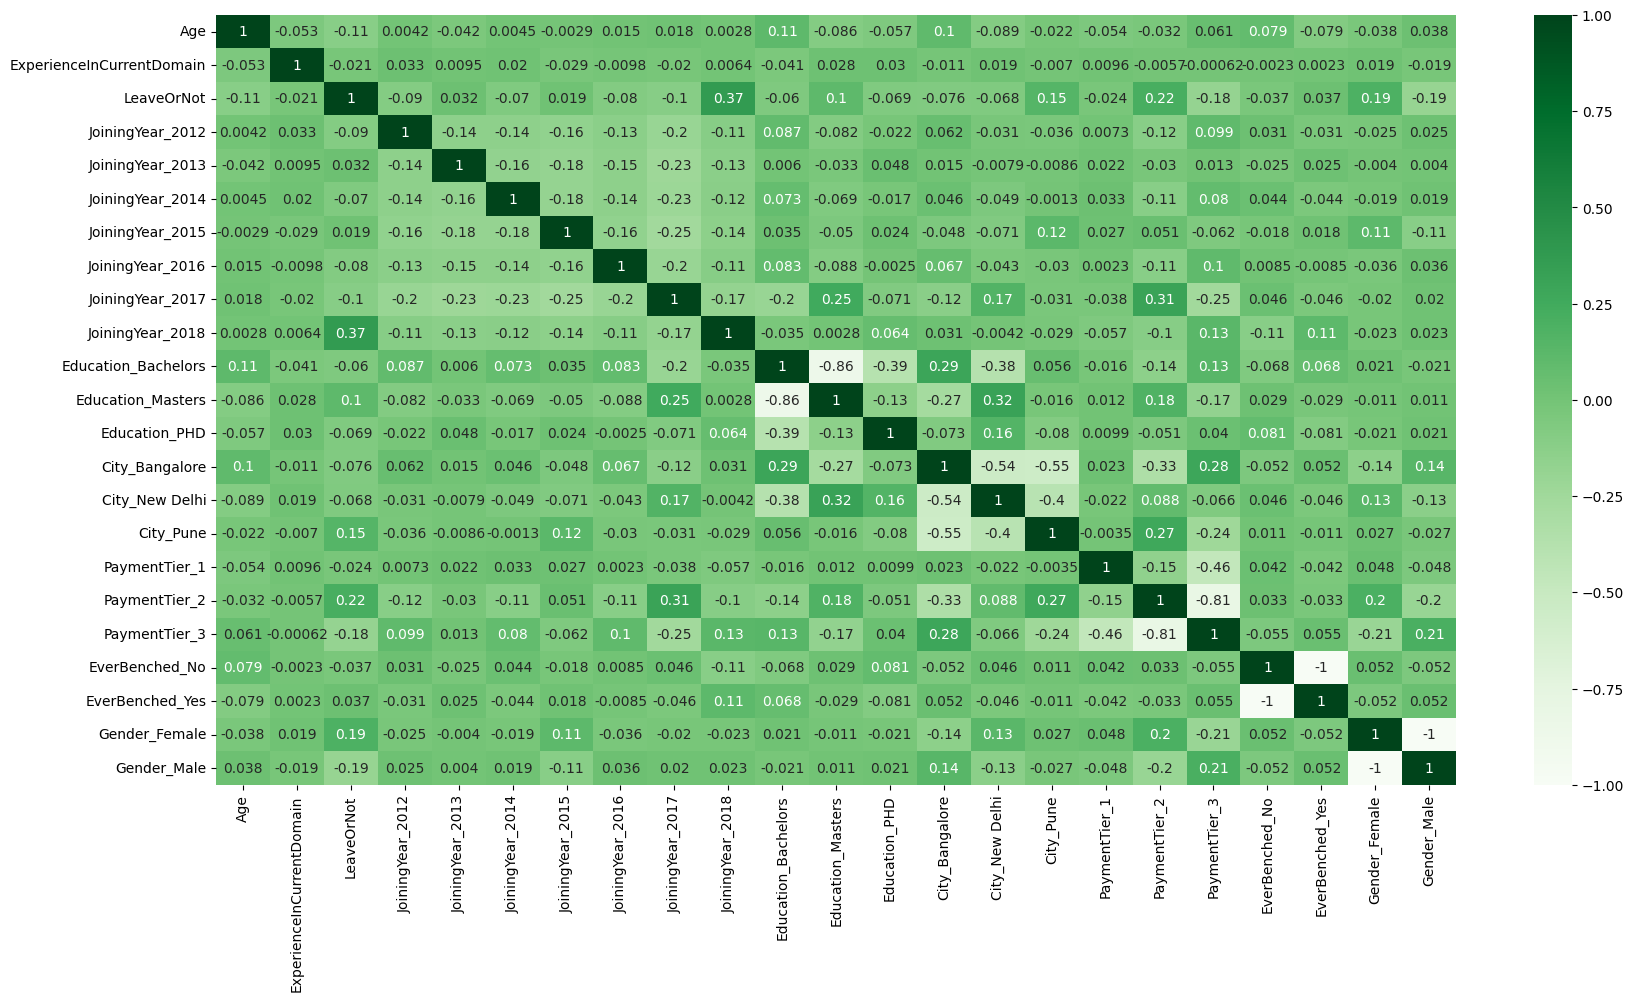

In [158]:
plt.figure(figsize=(20, 10))
sns.heatmap(df_dummies.corr(), annot=True, cmap="Greens")

In [159]:
# # từ bản tương quan có thể thấy rằng bằng thạc sĩ hoặc cử nhân có tương quang tương đương nhau nên có thểm drop 1 trong 2
corr_matrix = df_dummies.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.5)]
to_drop.remove("LeaveOrNot") if "LeaveOrNot" in to_drop else None
df_dummies.drop(to_drop, axis=1, inplace=True)

<Axes: >

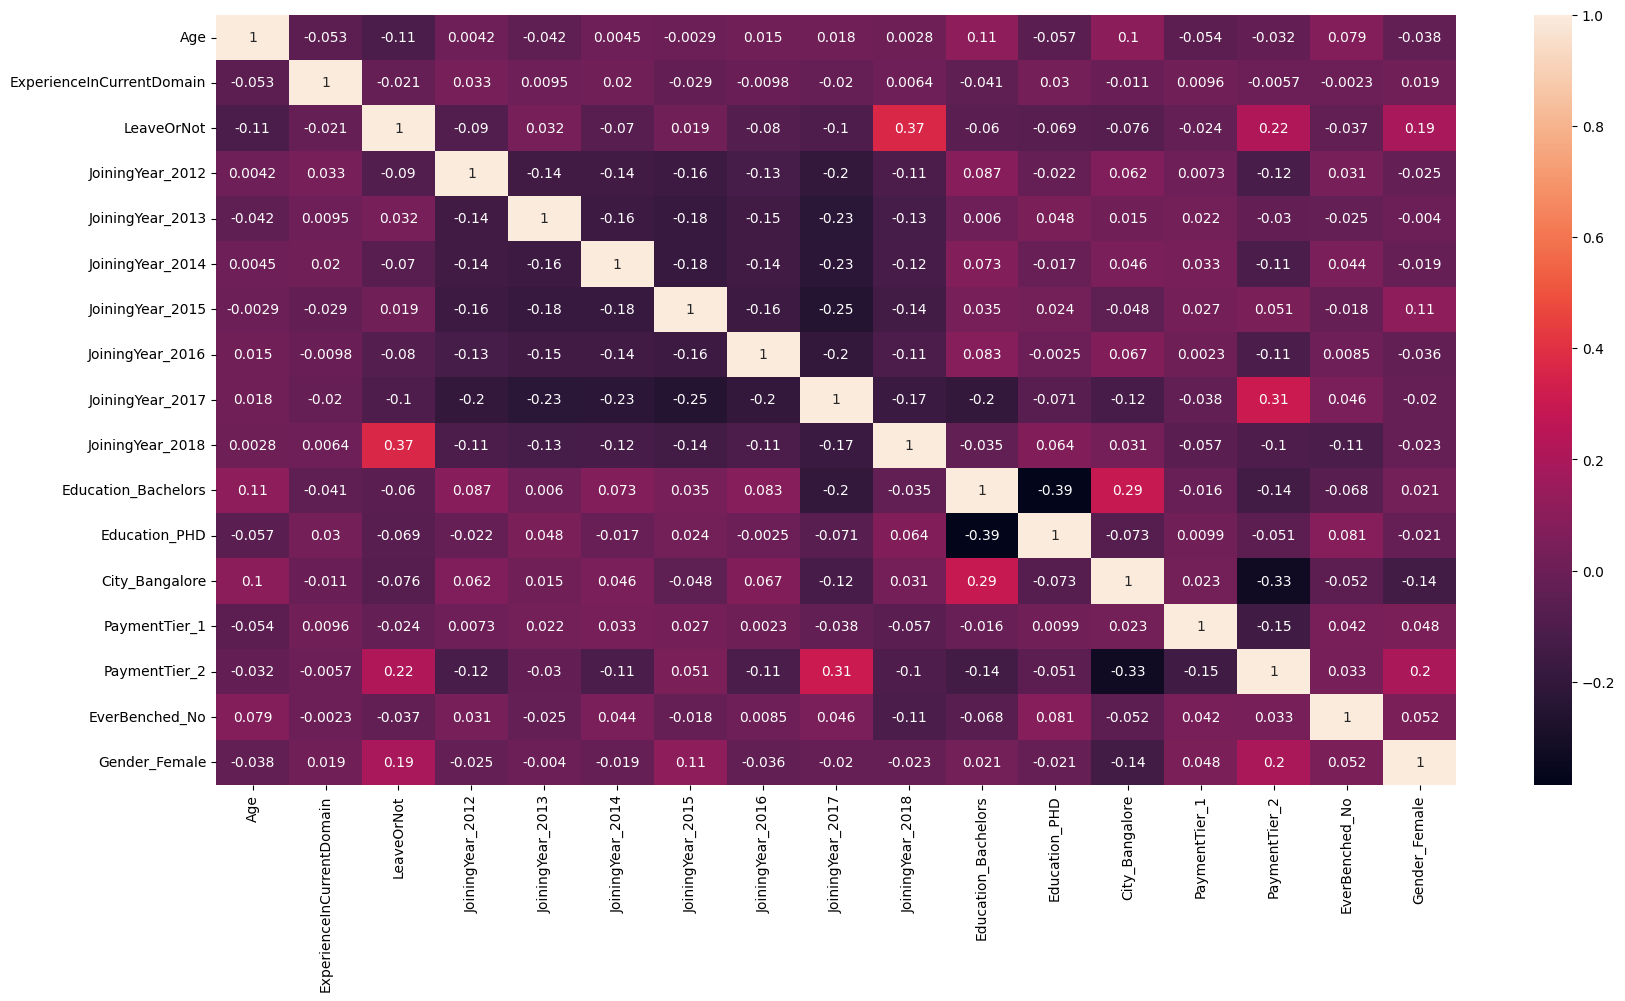

In [160]:
plt.figure(figsize=(20, 10))
sns.heatmap(df_dummies.corr(), annot=True)

#### Regularization

In [161]:
X = df_dummies.drop('LeaveOrNot', axis=1)
y = df_dummies['LeaveOrNot']

In [162]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.fit_transform(X)

In [163]:
X_scaled


array([[ 0.59652788, -1.64213199, -0.35412874, ..., -0.50970526,
         0.38759371, -0.89873103],
       [-0.57811215,  0.22085316, -0.35412874, ..., -0.50970526,
         0.38759371,  1.11267995],
       [ 1.37962124, -0.40014189, -0.35412874, ..., -0.50970526,
         0.38759371,  1.11267995],
       ...,
       [ 1.1838479 , -0.40014189, -0.35412874, ...,  1.96191814,
         0.38759371, -0.89873103],
       [-0.77388549,  1.46284326, -0.35412874, ..., -0.50970526,
         0.38759371, -0.89873103],
       [-0.18656548, -0.40014189,  2.82383179, ..., -0.50970526,
        -2.58002126, -0.89873103]])

In [164]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=5, test_size=0.3)

## Phần 2: Ứng dụng các mô hình học máy cơ bản để giải quyết bài toán, bao gồm cả các mô hình thuộc Ensemble Learing

### Các mô hình học máy cơ bản

#### KNN

In [165]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()

knn_clf.fit(X_train, y_train)
y_test_pred = knn_clf.predict(X_test)

knn_accuracy = accuracy_score(y_test, y_test_pred)
knn_precision = precision_score(y_test, y_test_pred)
knn_recall = recall_score(y_test, y_test_pred)
knn_f1 = f1_score(y_test, y_test_pred)

print_metrics(knn_accuracy, knn_precision, knn_recall, knn_f1)

Accuracy: 0.7470
Precision: 0.7273
Recall: 0.5662
F1-Score: 0.6367


In [166]:
y_train_pred = knn_clf.predict(X_train)

knn_train_accuracy = accuracy_score(y_train, y_train_pred)
knn_train_precision = precision_score(y_train, y_train_pred)
knn_train_recall = recall_score(y_train, y_train_pred)
knn_train_f1 = f1_score(y_train, y_train_pred)

print_metrics(knn_train_accuracy, knn_train_precision, knn_train_recall, knn_train_f1)

Accuracy: 0.8170
Precision: 0.8304
Recall: 0.6737
F1-Score: 0.7438


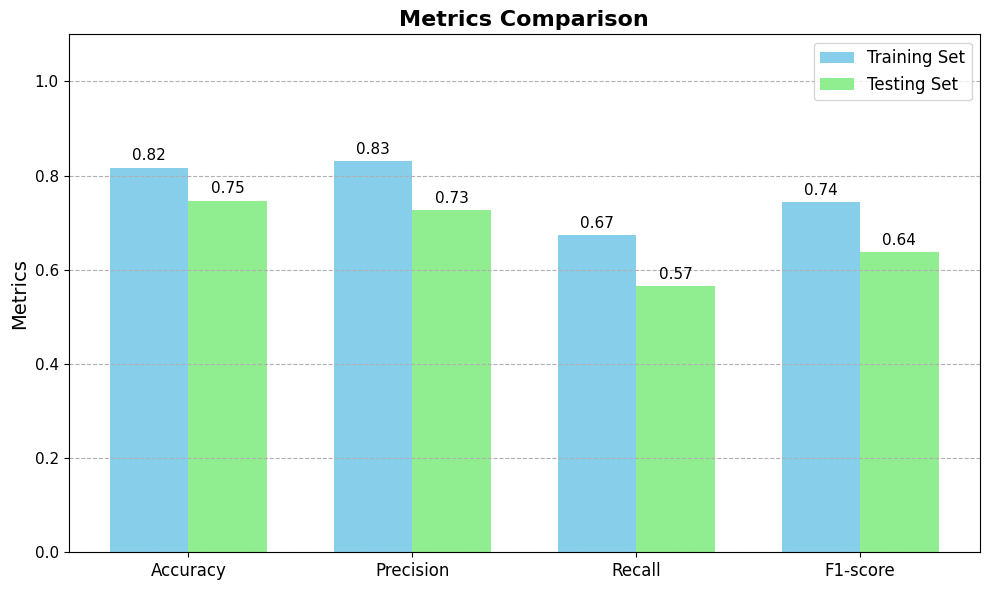

Độ chêch lệch giữa các giá trị metrics trên tập huấn luyện và tập kiểm tra: 
Accuracy: 0.07
Precision: 0.1031
Recall: 0.1075
F1-Score: 0.1072


In [167]:
training_metrics = [knn_train_accuracy, knn_train_precision, knn_train_recall, knn_train_f1]
testing_metrics = [knn_accuracy, knn_precision, knn_recall, knn_f1]

compare_metrics(training_metrics, testing_metrics)
compute_metric_difference(training_metrics, testing_metrics)

#### Decision Tree

In [168]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier()

dt_clf.fit(X_train, y_train)
y_test_pred = dt_clf.predict(X_test)

dt_accuracy = accuracy_score(y_test, y_test_pred)
dt_precision = precision_score(y_test, y_test_pred)
dt_recall = recall_score(y_test, y_test_pred)
dt_f1 = f1_score(y_test, y_test_pred)

print_metrics(dt_accuracy, dt_precision, dt_recall, dt_f1)

Accuracy: 0.6807
Precision: 0.5968
Recall: 0.5692
F1-Score: 0.5827


In [169]:
y_train_pred = dt_clf.predict(X_train)

dt_train_accuracy = accuracy_score(y_train, y_train_pred)
dt_train_precision = precision_score(y_train, y_train_pred)
dt_train_recall = recall_score(y_train, y_train_pred)
dt_train_f1 = f1_score(y_train, y_train_pred)

print_metrics(dt_train_accuracy, dt_train_precision, dt_train_recall, dt_train_f1)

Accuracy: 0.9230
Precision: 0.9812
Recall: 0.8204
F1-Score: 0.8936


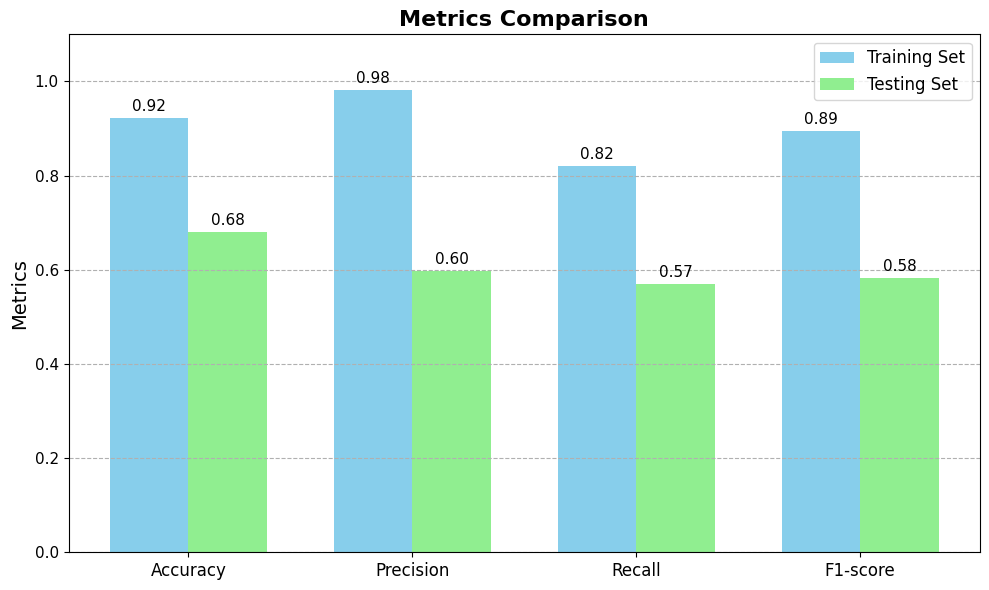

Độ chêch lệch giữa các giá trị metrics trên tập huấn luyện và tập kiểm tra: 
Accuracy: 0.2422
Precision: 0.3844
Recall: 0.2512
F1-Score: 0.311


In [170]:
training_metrics = [dt_train_accuracy, dt_train_precision, dt_train_recall, dt_train_f1]
testing_metrics = [dt_accuracy, dt_precision, dt_recall, dt_f1]

compare_metrics(training_metrics, testing_metrics)
compute_metric_difference(training_metrics, testing_metrics)

#### Naive Bayes

In [171]:
from sklearn.naive_bayes import GaussianNB

nb_clf = GaussianNB()

nb_clf.fit(X_train, y_train)
y_test_pred = nb_clf.predict(X_test)

nb_accuracy = accuracy_score(y_test, y_test_pred)
nb_precision = precision_score(y_test, y_test_pred)
nb_recall = recall_score(y_test, y_test_pred)
nb_f1 = f1_score(y_test, y_test_pred)

print_metrics(nb_accuracy, nb_precision, nb_recall, nb_f1)

Accuracy: 0.7217
Precision: 0.8176
Recall: 0.3723
F1-Score: 0.5116


In [172]:
y_train_pred = nb_clf.predict(X_train)

nb_train_accuracy = accuracy_score(y_train, y_train_pred)
nb_train_precision = precision_score(y_train, y_train_pred)
nb_train_recall = recall_score(y_train, y_train_pred)
nb_train_f1 = f1_score(y_train, y_train_pred)

print_metrics(nb_train_accuracy, nb_train_precision, nb_train_recall, nb_train_f1)

Accuracy: 0.7358
Precision: 0.8539
Recall: 0.3984
F1-Score: 0.5433


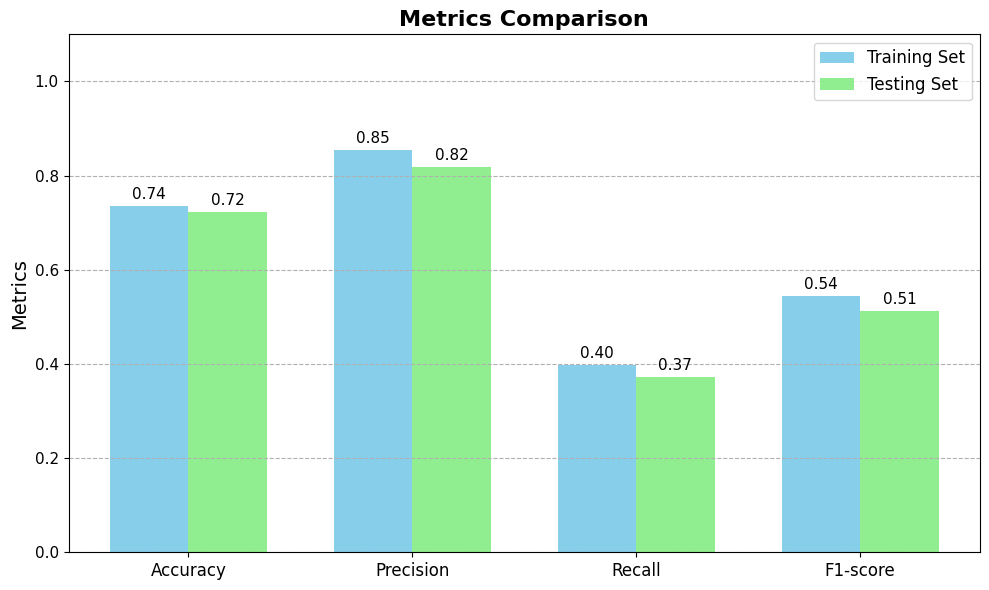

Độ chêch lệch giữa các giá trị metrics trên tập huấn luyện và tập kiểm tra: 
Accuracy: 0.0141
Precision: 0.0364
Recall: 0.0261
F1-Score: 0.0317


In [173]:
training_metrics = [nb_train_accuracy, nb_train_precision, nb_train_recall, nb_train_f1]
testing_metrics = [nb_accuracy, nb_precision, nb_recall, nb_f1]

compare_metrics(training_metrics, testing_metrics)
compute_metric_difference(training_metrics, testing_metrics)

#### SVM

In [583]:
from sklearn.svm import LinearSVC

svm_clf = LinearSVC()

svm_clf.fit(X_train, y_train)
y_test_pred = svm_clf.predict(X_test)

svm_accuracy = accuracy_score(y_test, y_test_pred)
svm_precision = precision_score(y_test, y_test_pred)
svm_recall = recall_score(y_test, y_test_pred)
svm_f1 = f1_score(y_test, y_test_pred)

print_metrics(svm_accuracy, svm_precision, svm_recall, svm_f1)

Accuracy: 0.7301
Precision: 0.7149
Recall: 0.5169
F1-Score: 0.6000


c:\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [175]:
y_train_pred = svm_clf.predict(X_train)

svm_train_accuracy = accuracy_score(y_train, y_train_pred)
svm_train_precision = precision_score(y_train, y_train_pred)
svm_train_recall = recall_score(y_train, y_train_pred)
svm_train_f1 = f1_score(y_train, y_train_pred)

print_metrics(svm_train_accuracy, svm_train_precision, svm_train_recall, svm_train_f1)

Accuracy: 0.7549
Precision: 0.7784
Recall: 0.5295
F1-Score: 0.6303


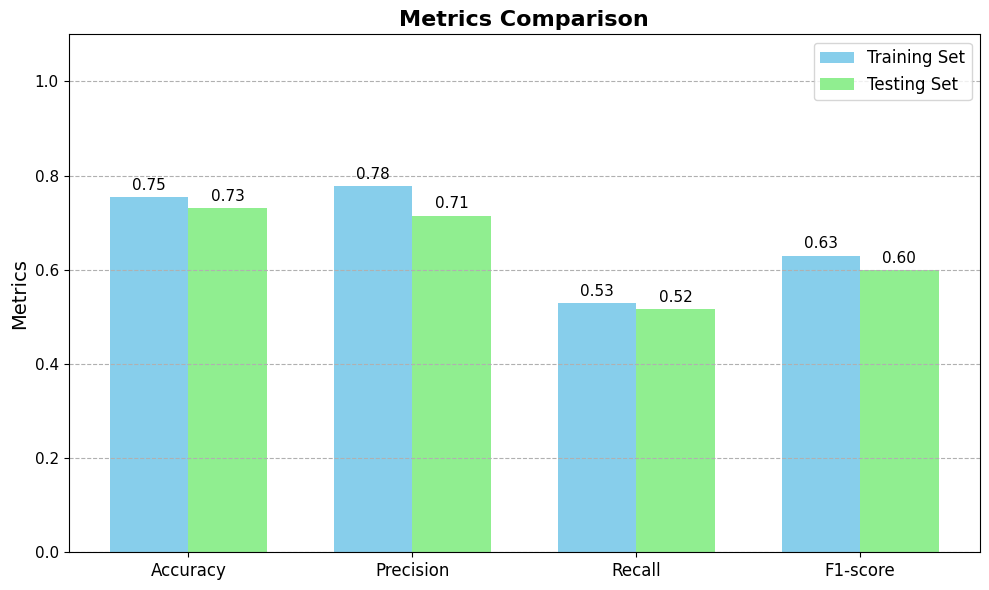

Độ chêch lệch giữa các giá trị metrics trên tập huấn luyện và tập kiểm tra: 
Accuracy: 0.0248
Precision: 0.0635
Recall: 0.0126
F1-Score: 0.0303


In [176]:
training_metrics = [svm_train_accuracy, svm_train_precision, svm_train_recall, svm_train_f1]
testing_metrics = [svm_accuracy, svm_precision, svm_recall, svm_f1]

compare_metrics(training_metrics, testing_metrics)
compute_metric_difference(training_metrics, testing_metrics)

#### Logistic Regression

In [177]:
from sklearn.linear_model import LogisticRegression

logistic_clf = LogisticRegression()

logistic_clf.fit(X_train, y_train)
y_test_pred = logistic_clf.predict(X_test)

logistic_accuracy = accuracy_score(y_test, y_test_pred)
logistic_precision = precision_score(y_test, y_test_pred)
logistic_recall = recall_score(y_test, y_test_pred)
logistic_f1 = f1_score(y_test, y_test_pred)

print_metrics(logistic_accuracy, logistic_precision, logistic_recall, logistic_f1)

Accuracy: 0.7337
Precision: 0.7097
Recall: 0.5415
F1-Score: 0.6143


In [178]:
y_train_pred = dt_clf.predict(X_train)

logistic_train_accuracy = accuracy_score(y_train, y_train_pred)
logistic_train_precision = precision_score(y_train, y_train_pred)
logistic_train_recall = recall_score(y_train, y_train_pred)
logistic_train_f1 = f1_score(y_train, y_train_pred)

print_metrics(logistic_train_accuracy, logistic_train_precision, logistic_train_recall, logistic_train_f1)

Accuracy: 0.9230
Precision: 0.9812
Recall: 0.8204
F1-Score: 0.8936


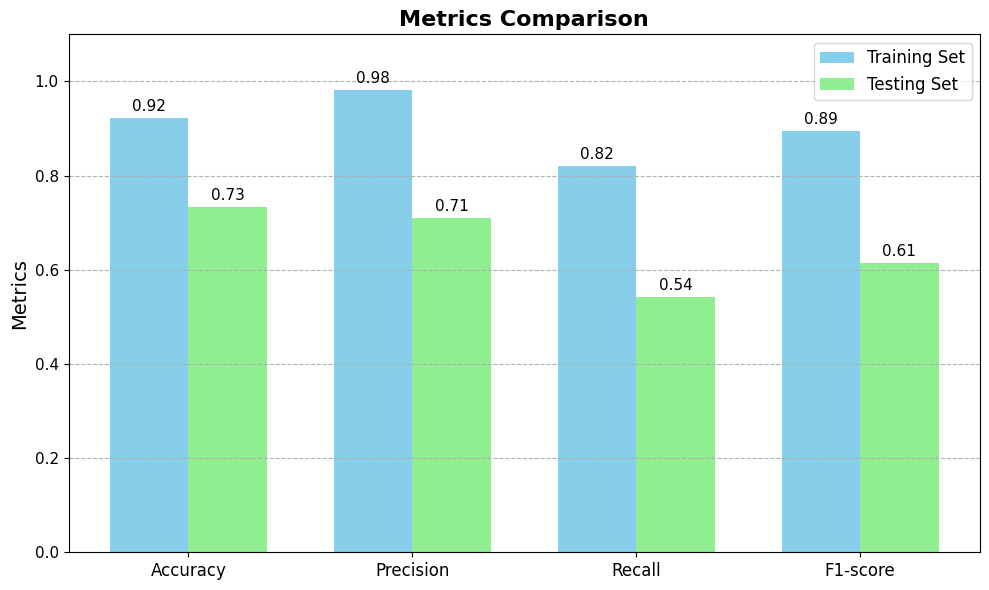

Độ chêch lệch giữa các giá trị metrics trên tập huấn luyện và tập kiểm tra: 
Accuracy: 0.1892
Precision: 0.2715
Recall: 0.2789
F1-Score: 0.2793


In [179]:
training_metrics = [logistic_train_accuracy, logistic_train_precision, logistic_train_recall, logistic_train_f1]
testing_metrics = [logistic_accuracy, logistic_precision, logistic_recall, logistic_f1]

compare_metrics(training_metrics, testing_metrics)
compute_metric_difference(training_metrics, testing_metrics)

### Các mô hình học máy thuộc Ensemble Learing

#### Gradient Boosting

In [588]:
from sklearn.ensemble import GradientBoostingClassifier

gb_clf = GradientBoostingClassifier()

gb_clf.fit(X_train, y_train)
y_test_pred = gb_clf.predict(X_test)

gb_accuracy_before = accuracy_score(y_test, y_test_pred)
gb_precision_before = precision_score(y_test, y_test_pred)
gb_recall_before = recall_score(y_test, y_test_pred)
gb_f1_before = f1_score(y_test, y_test_pred)

print_metrics(gb_accuracy_before, gb_precision_before, gb_recall_before, gb_f1_before)

Accuracy: 0.7578
Precision: 0.7696
Recall: 0.5446
F1-Score: 0.6378


In [589]:
y_train_pred = gb_clf.predict(X_train)

gb_train_accuracy = accuracy_score(y_train, y_train_pred)
gb_train_precision = precision_score(y_train, y_train_pred)
gb_train_recall = recall_score(y_train, y_train_pred)
gb_train_f1 = f1_score(y_train, y_train_pred)

print_metrics(gb_train_accuracy, gb_train_precision, gb_train_recall, gb_train_f1)

Accuracy: 0.8030
Precision: 0.8631
Recall: 0.5950
F1-Score: 0.7044


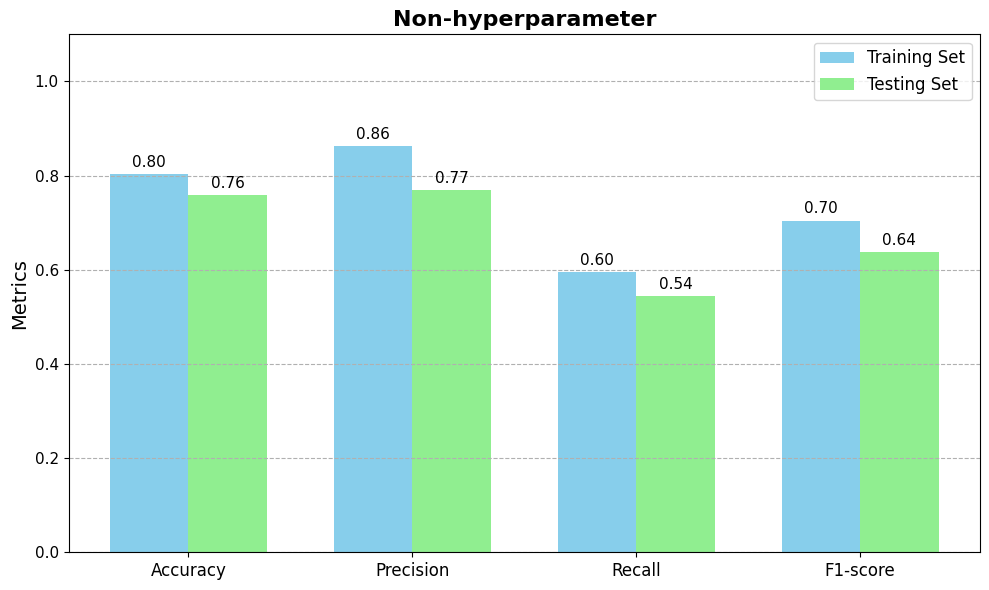

Độ chêch lệch giữa các giá trị metrics trên tập huấn luyện và tập kiểm tra: 
Accuracy: 0.0452
Precision: 0.0936
Recall: 0.0504
F1-Score: 0.0666


In [590]:
gb_training_metrics_before = [gb_train_accuracy, gb_train_precision, gb_train_recall, gb_train_f1]
gb_testing_metrics_before = [gb_accuracy_before, gb_precision_before, gb_recall_before, gb_f1_before]

compare_metrics(gb_training_metrics_before, gb_testing_metrics_before, title_1)
compute_metric_difference(gb_training_metrics_before, gb_testing_metrics_before)

#### AdaBoost

In [593]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier()

ada_clf.fit(X_train, y_train)
y_test_pred = ada_clf.predict(X_test)

ada_accuracy_before = accuracy_score(y_test, y_test_pred)
ada_precision_before = precision_score(y_test, y_test_pred)
ada_recall_before = recall_score(y_test, y_test_pred)
ada_f1_before = f1_score(y_test, y_test_pred)

print_metrics(ada_accuracy_before, ada_precision_before, ada_recall_before, ada_f1_before)

Accuracy: 0.7157
Precision: 0.6831
Recall: 0.5108
F1-Score: 0.5845


In [595]:
y_train_pred = ada_clf.predict(X_train)

ada_train_accuracy = accuracy_score(y_train, y_train_pred)
ada_train_precision = precision_score(y_train, y_train_pred)
ada_train_recall = recall_score(y_train, y_train_pred)
ada_train_f1 = f1_score(y_train, y_train_pred)

print_metrics(ada_train_accuracy, ada_train_precision, ada_train_recall, ada_train_f1)

Accuracy: 0.7616
Precision: 0.7726
Recall: 0.5609
F1-Score: 0.6500


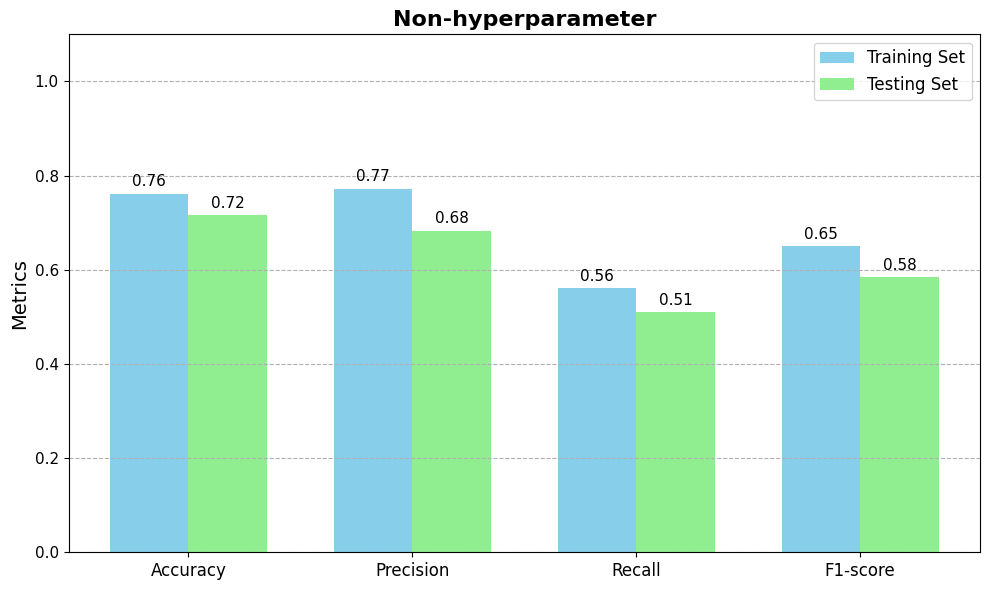

Độ chêch lệch giữa các giá trị metrics trên tập huấn luyện và tập kiểm tra: 
Accuracy: 0.046
Precision: 0.0894
Recall: 0.0502
F1-Score: 0.0655


In [596]:
ada_training_metrics_before = [ada_train_accuracy, ada_train_precision, ada_train_recall, ada_train_f1]
ada_testing_metrics_before = [ada_accuracy_before, ada_precision_before, ada_recall_before, ada_f1_before]

compare_metrics(ada_training_metrics_before, ada_testing_metrics_before, title_1)
compute_metric_difference(ada_training_metrics_before, ada_testing_metrics_before)

#### Bagging

In [600]:
from sklearn.ensemble import BaggingClassifier

bg_clf = BaggingClassifier()

bg_clf.fit(X_train, y_train)
y_test_pred = bg_clf.predict(X_test)

bg_accuracy_before = accuracy_score(y_test, y_test_pred)
bg_precision_before = precision_score(y_test, y_test_pred)
bg_recall_before = recall_score(y_test, y_test_pred)
bg_f1_before = f1_score(y_test, y_test_pred)

print_metrics(bg_accuracy_before, bg_precision_before, bg_recall_before, bg_f1_before)

Accuracy: 0.7024
Precision: 0.6275
Recall: 0.5908
F1-Score: 0.6086


In [602]:
y_train_pred = bg_clf.predict(X_train)

bg_train_accuracy = accuracy_score(y_train, y_train_pred)
bg_train_precision = precision_score(y_train, y_train_pred)
bg_train_recall = recall_score(y_train, y_train_pred)
bg_train_f1 = f1_score(y_train, y_train_pred)

print_metrics(bg_train_accuracy, bg_train_precision, bg_train_recall, bg_train_f1)

Accuracy: 0.9121
Precision: 0.9023
Recall: 0.8716
F1-Score: 0.8867


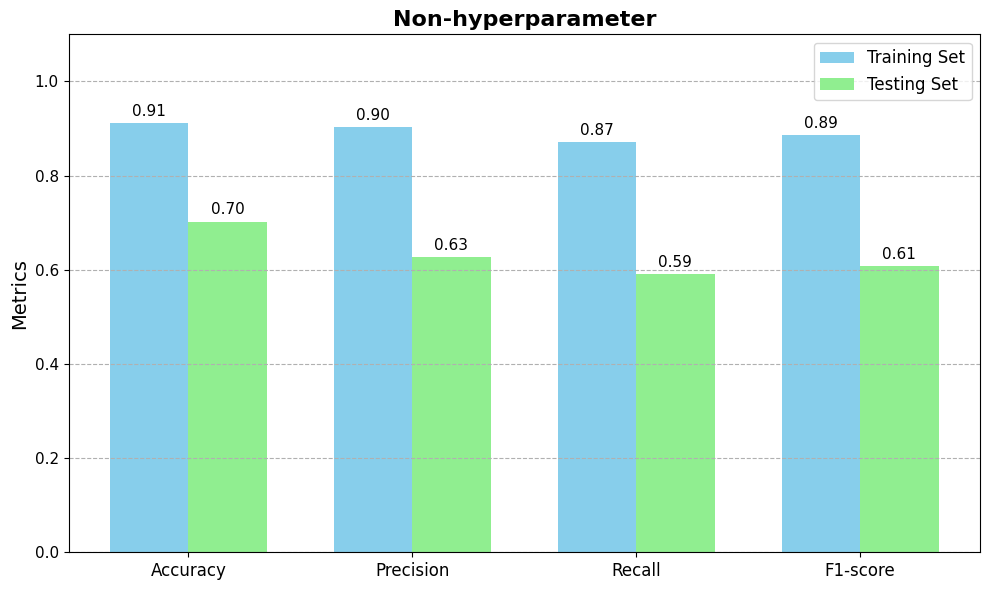

Độ chêch lệch giữa các giá trị metrics trên tập huấn luyện và tập kiểm tra: 
Accuracy: 0.2097
Precision: 0.2749
Recall: 0.2808
F1-Score: 0.2781


In [603]:
bg_training_metrics_before = [bg_train_accuracy, bg_train_precision, bg_train_recall, bg_train_f1]
bg_testing_metrics_before = [bg_accuracy_before, bg_precision_before, bg_recall_before, bg_f1_before]

compare_metrics(bg_training_metrics_before, bg_testing_metrics_before, title_1)
compute_metric_difference(bg_training_metrics_before, bg_testing_metrics_before)

#### Random Forest

In [604]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()

rf_clf.fit(X_train, y_train)
y_test_pred = rf_clf.predict(X_test)

rf_accuracy_before = accuracy_score(y_test, y_test_pred)
rf_precision_before = precision_score(y_test, y_test_pred)
rf_recall_before = recall_score(y_test, y_test_pred)
rf_f1_before = f1_score(y_test, y_test_pred)

print_metrics(rf_accuracy_before, rf_precision_before, rf_recall_before, rf_f1_before)

Accuracy: 0.7072
Precision: 0.6376
Recall: 0.5846
F1-Score: 0.6100


In [605]:
y_train_pred = rf_clf.predict(X_train)

rf_train_accuracy = accuracy_score(y_train, y_train_pred)
rf_train_precision = precision_score(y_train, y_train_pred)
rf_train_recall = recall_score(y_train, y_train_pred)
rf_train_f1 = f1_score(y_train, y_train_pred)

print_metrics(rf_train_accuracy, rf_train_precision, rf_train_recall, rf_train_f1)

Accuracy: 0.9230
Precision: 0.9264
Recall: 0.8742
F1-Score: 0.8995


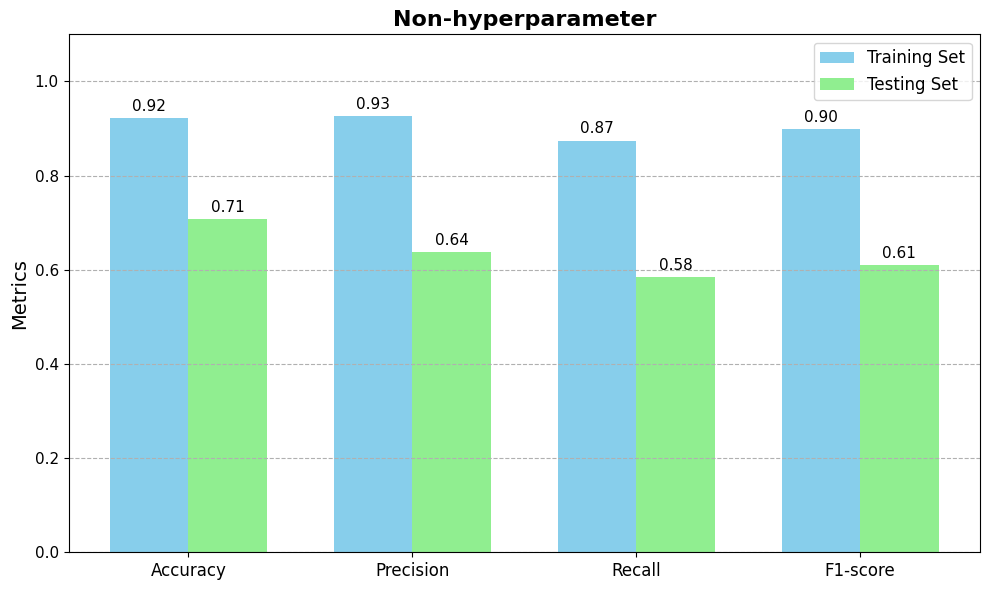

Độ chêch lệch giữa các giá trị metrics trên tập huấn luyện và tập kiểm tra: 
Accuracy: 0.2157
Precision: 0.2888
Recall: 0.2896
F1-Score: 0.2896


In [607]:
rf_training_metrics_before = [rf_train_accuracy, rf_train_precision, rf_train_recall, rf_train_f1]
rf_testing_metrics_before = [rf_accuracy_before, rf_precision_before, rf_recall_before, rf_f1_before]

compare_metrics(rf_training_metrics_before, rf_testing_metrics_before, title_1)
compute_metric_difference(rf_training_metrics_before, rf_testing_metrics_before)

#### Voting Classifier

In [610]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

gb_clf = GradientBoostingClassifier()
lr_clf = LogisticRegression()
rf_clf = RandomForestClassifier()

vt_clf = VotingClassifier(
    estimators=[('rf', rf_clf), ('gb', gb_clf), ('lr', lr_clf)]
)

vt_clf.fit(X_train, y_train)
y_test_pred = vt_clf.predict(X_test)

vt_accuracy_before = accuracy_score(y_test, y_test_pred)
vt_precision_before = precision_score(y_test, y_test_pred)
vt_recall_before = recall_score(y_test, y_test_pred)
vt_f1_before = f1_score(y_test, y_test_pred)

print_metrics(vt_accuracy_before, vt_precision_before, vt_recall_before, vt_f1_before)

Accuracy: 0.7506
Precision: 0.7398
Recall: 0.5600
F1-Score: 0.6375


In [611]:
y_train_pred = vt_clf.predict(X_train)

vt_train_accuracy = accuracy_score(y_train, y_train_pred)
vt_train_precision = precision_score(y_train, y_train_pred)
vt_train_recall = recall_score(y_train, y_train_pred)
vt_train_f1 = f1_score(y_train, y_train_pred)

print_metrics(vt_train_accuracy, vt_train_precision, vt_train_recall, vt_train_f1)

Accuracy: 0.8232
Precision: 0.8877
Recall: 0.6317
F1-Score: 0.7381


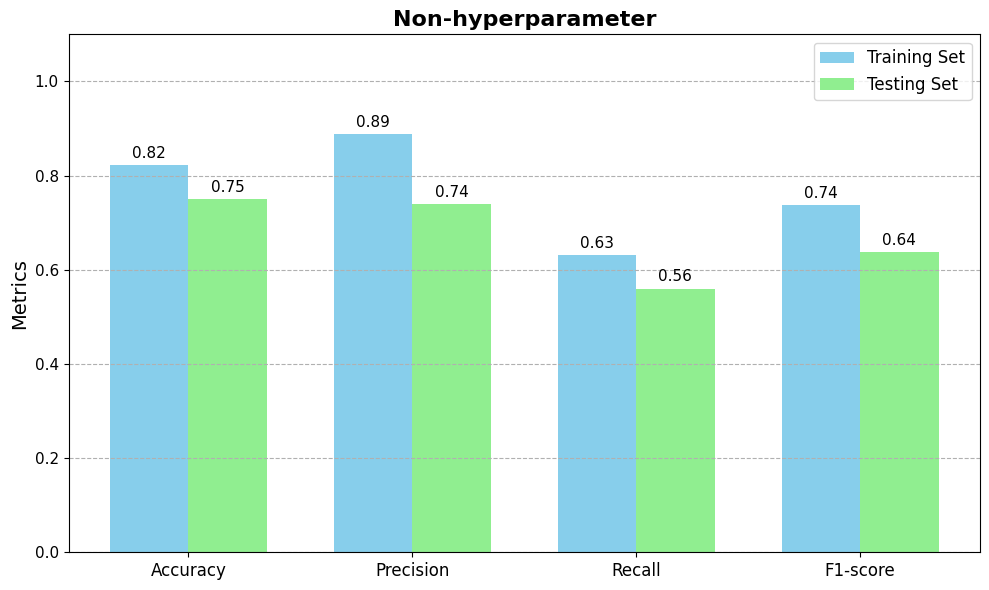

Độ chêch lệch giữa các giá trị metrics trên tập huấn luyện và tập kiểm tra: 
Accuracy: 0.0726
Precision: 0.1478
Recall: 0.0717
F1-Score: 0.1007


In [613]:
vt_training_metrics_before = [vt_train_accuracy, vt_train_precision, vt_train_recall, vt_train_f1]
vt_testing_metrics_before = [vt_accuracy_before, vt_precision_before, vt_recall_before, vt_f1_before]

compare_metrics(vt_training_metrics_before, vt_testing_metrics_before, title_1)
compute_metric_difference(vt_training_metrics_before, vt_testing_metrics_before)

#### Stacking

In [614]:
from sklearn.ensemble import StackingClassifier

st_clf = StackingClassifier(
    estimators=[('rf', rf_clf), ('gb', gb_clf)],
    final_estimator=lr_clf
)

st_clf.fit(X_train, y_train)
y_test_pred = st_clf.predict(X_test)

st_accuracy_before = accuracy_score(y_test, y_test_pred)
st_precision_before = precision_score(y_test, y_test_pred)
st_recall_before = recall_score(y_test, y_test_pred)
st_f1_before = f1_score(y_test, y_test_pred)

print_metrics(st_accuracy_before, st_precision_before, st_recall_before, st_f1_before)

Accuracy: 0.7566
Precision: 0.7552
Recall: 0.5600
F1-Score: 0.6431


In [615]:
y_train_pred = st_clf.predict(X_train)

st_train_accuracy = accuracy_score(y_train, y_train_pred)
st_train_precision = precision_score(y_train, y_train_pred)
st_train_recall = recall_score(y_train, y_train_pred)
st_train_f1 = f1_score(y_train, y_train_pred)

print_metrics(st_train_accuracy, st_train_precision, st_train_recall, st_train_f1)

Accuracy: 0.7797
Precision: 0.8014
Recall: 0.5872
F1-Score: 0.6778


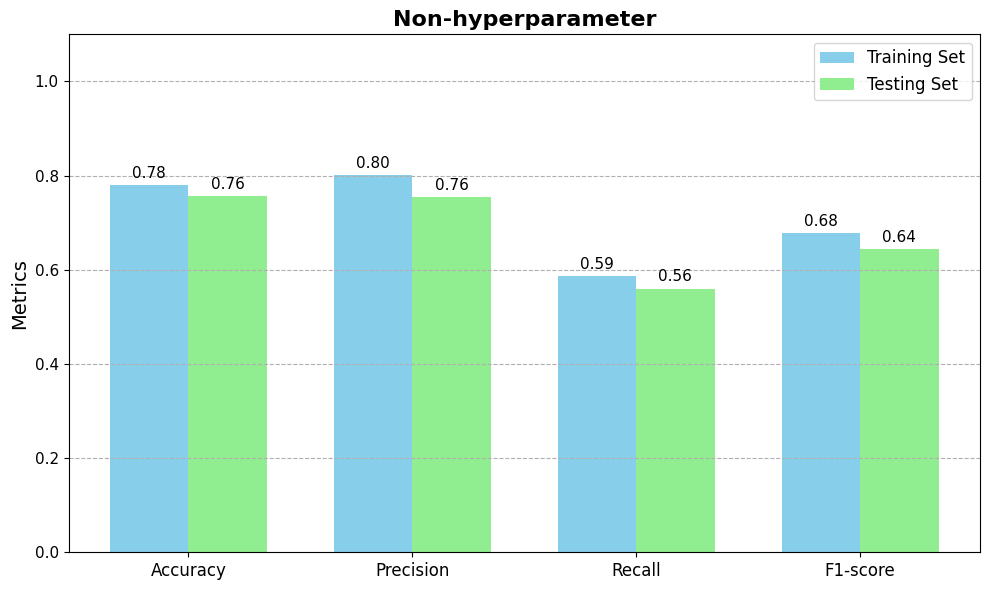

Độ chêch lệch giữa các giá trị metrics trên tập huấn luyện và tập kiểm tra: 
Accuracy: 0.0231
Precision: 0.0462
Recall: 0.0272
F1-Score: 0.0347


In [617]:
st_training_metrics_before = [st_train_accuracy, st_train_precision, st_train_recall, st_train_f1]
st_testing_metrics_before = [st_accuracy_before, st_precision_before, st_recall_before, st_f1_before]

compare_metrics(st_training_metrics_before, st_testing_metrics_before, title_1)
compute_metric_difference(st_training_metrics_before, st_testing_metrics_before)

#### Hàm visualize_metrics sử dụng để so sánh hiệu suất của nhiều bộ phân loại (classifiers) khác nhau dựa trên các độ đo đánh giá như accuracy (độ chính xác), precision (độ chính xác dương tính), recall (độ phục hồi), và F1-score.

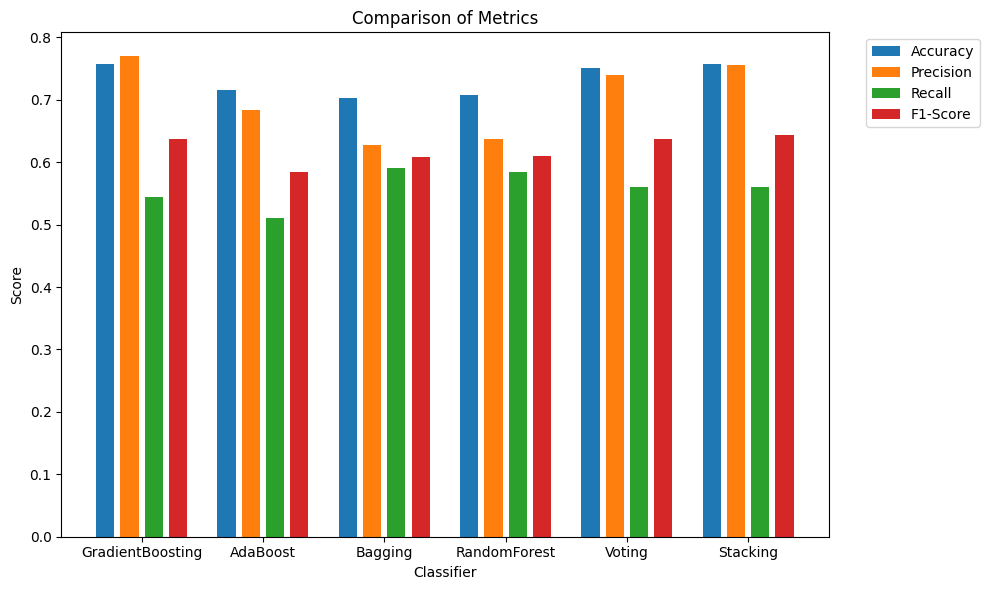

In [618]:

metrics = {
    'GradientBoosting': {
        'Accuracy': gb_accuracy_before,
        'Precision': gb_precision_before,
        'Recall': gb_recall_before,
        'F1-Score': gb_f1_before
    },

    'AdaBoost': {
        'Accuracy': ada_accuracy_before,
        'Precision': ada_precision_before,
        'Recall': ada_recall_before,
        'F1-Score': ada_f1_before
    },

    'Bagging': {
        'Accuracy': bg_accuracy_before,
        'Precision': bg_precision_before,
        'Recall': bg_recall_before,
        'F1-Score': bg_f1_before
    },

    'RandomForest': {
        'Accuracy': rf_accuracy_before,
        'Precision': rf_precision_before,
        'Recall': rf_recall_before,
        'F1-Score': rf_f1_before
    },

    'Voting': {
        'Accuracy': vt_accuracy_before,
        'Precision': vt_precision_before,
        'Recall': vt_recall_before,
        'F1-Score': vt_f1_before
    },

    'Stacking': {
        'Accuracy': st_accuracy_before,
        'Precision': st_precision_before,
        'Recall': st_recall_before,
        'F1-Score': st_f1_before
    }
}

visualize_metrics(metrics=metrics)


##### Tổng quan các mô hình trên

Gradient Boosting và Stacking là hai phương pháp có hiệu suất tốt hơn so với các phương pháp còn lại. Cả hai phương pháp này đạt được độ chính xác, độ chính xác dương tính, độ chính xác phân loại và F1-Score tốt trên tập kiểm tra. Voting Classifier cũng cho thấy hiệu suất tương đối cao, trong khi Random Forest, Ada Boosting và Bagging có hiệu suất trung bình. 

## Phần 3: Sử dụng Feed Forward Neural Network và Reccurent Neural Network (hoặc mô thuộc loại này) để giải quyết bài toán

### Feed Forward Neurl Network


Epoch 1/100
61/61 [==============================] - 1s 4ms/step - loss: 0.6695 - accuracy: 0.6489 - val_loss: 0.6512 - val_accuracy: 0.7181
Epoch 2/100
61/61 [==============================] - 0s 2ms/step - loss: 0.6420 - accuracy: 0.7239 - val_loss: 0.6287 - val_accuracy: 0.7325
Epoch 3/100
61/61 [==============================] - 0s 2ms/step - loss: 0.6208 - accuracy: 0.7373 - val_loss: 0.6115 - val_accuracy: 0.7277
Epoch 4/100
61/61 [==============================] - 0s 2ms/step - loss: 0.6038 - accuracy: 0.7487 - val_loss: 0.5973 - val_accuracy: 0.7301
Epoch 5/100
61/61 [==============================] - 0s 2ms/step - loss: 0.5901 - accuracy: 0.7472 - val_loss: 0.5863 - val_accuracy: 0.7289
Epoch 6/100
61/61 [==============================] - 0s 2ms/step - loss: 0.5789 - accuracy: 0.7534 - val_loss: 0.5771 - val_accuracy: 0.7349
Epoch 7/100
61/61 [==============================] - 0s 2ms/step - loss: 0.5694 - accuracy: 0.7508 - val_loss: 0.5695 - val_accuracy: 0.7337
Epoch 8/100
6

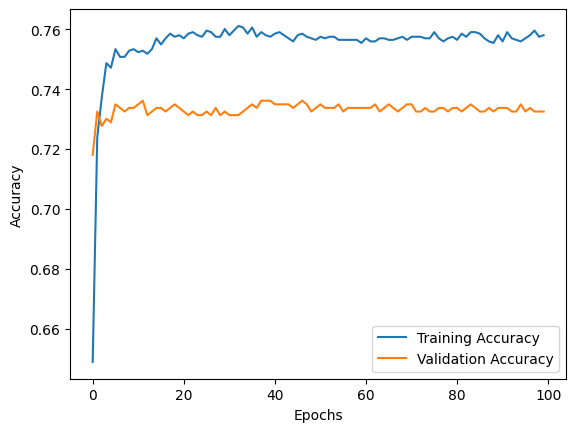

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 1)                 17        
                                                                 
Total params: 17 (68.00 Byte)
Trainable params: 17 (68.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [199]:
model_FFNW = tf.keras.Sequential([
    tf.keras.layers.Dense(1, kernel_initializer='uniform', activation='sigmoid'),
])

model_FFNW.compile(loss="binary_crossentropy", metrics='accuracy', optimizer='adam')

history_FFNW_before = model_FFNW.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

plot_accuracy_history(history_FFNW_before)

print(model_FFNW.summary())

### Reccurent Neural Network

Epoch 1/100
61/61 [==============================] - 1s 6ms/step - loss: 0.9449 - accuracy: 0.4949 - val_loss: 0.9328 - val_accuracy: 0.4953
Epoch 2/100
61/61 [==============================] - 0s 3ms/step - loss: 0.9157 - accuracy: 0.5020 - val_loss: 0.9048 - val_accuracy: 0.4992
Epoch 3/100
61/61 [==============================] - 0s 4ms/step - loss: 0.8894 - accuracy: 0.5055 - val_loss: 0.8794 - val_accuracy: 0.5020
Epoch 4/100
61/61 [==============================] - 0s 3ms/step - loss: 0.8654 - accuracy: 0.5081 - val_loss: 0.8564 - val_accuracy: 0.5064
Epoch 5/100
61/61 [==============================] - 0s 3ms/step - loss: 0.8438 - accuracy: 0.5126 - val_loss: 0.8354 - val_accuracy: 0.5115
Epoch 6/100
61/61 [==============================] - 0s 3ms/step - loss: 0.8241 - accuracy: 0.5358 - val_loss: 0.8166 - val_accuracy: 0.5374
Epoch 7/100
61/61 [==============================] - 0s 3ms/step - loss: 0.8062 - accuracy: 0.5460 - val_loss: 0.7992 - val_accuracy: 0.5447
Epoch 8/100
6

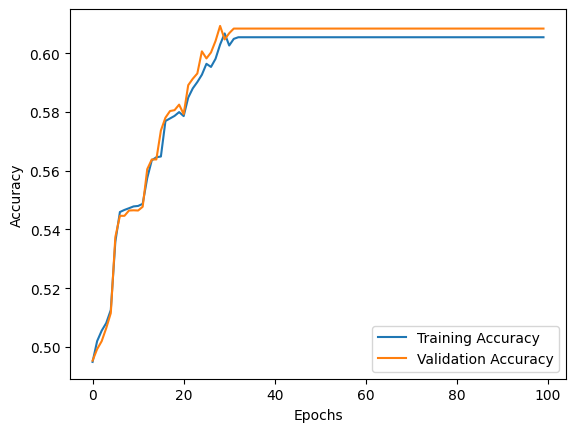

In [200]:
model_RNN = Sequential([
    tf.keras.layers.SimpleRNN(units = 1, activation='sigmoid', return_sequences=True, input_shape= (X_train.shape[1],1))
])

model_RNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_RNN_before = model_RNN.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

plot_accuracy_history(history_RNN_before)


## Phần 4: Áp dụng các kỹ thuật tránh Overfiting trên các mô hình của câu (2) và câu (3) để giải quyết bài toán

### Các mô hình học máy cơ bản

#### KNN

In [201]:
knn_clf = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [4, 6, 8, 10, 12],
    'weights': ['uniform', 'distance'],
    'p': [1, 2],
    'algorithm': ['auto']
}

grid_search = GridSearchCV(knn_clf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_params


{'algorithm': 'auto', 'n_neighbors': 12, 'p': 1, 'weights': 'uniform'}

In [202]:
best_knn_clf = grid_search.best_estimator_
y_test_pred = best_knn_clf.predict(X_test)

best_knn_accuracy = accuracy_score(y_test, y_test_pred)
best_knn_precision = precision_score(y_test, y_test_pred)
best_knn_recall = recall_score(y_test, y_test_pred)
best_knn_f1 = f1_score(y_test, y_test_pred)

print_metrics(best_knn_accuracy, best_knn_precision, best_knn_recall, best_knn_f1)


Accuracy: 0.7566
Precision: 0.8289
Recall: 0.4769
F1-Score: 0.6055


In [203]:
y_train_pred = best_knn_clf.predict(X_train)

best_knn_train_accuracy = accuracy_score(y_train, y_train_pred)
best_knn_train_precision = precision_score(y_train, y_train_pred)
best_knn_train_recall = recall_score(y_train, y_train_pred)
best_knn_train_f1 = f1_score(y_train, y_train_pred)

print_metrics(best_knn_train_accuracy, best_knn_train_precision, best_knn_train_recall, best_knn_train_f1)

Accuracy: 0.7921
Precision: 0.9020
Recall: 0.5308
F1-Score: 0.6683


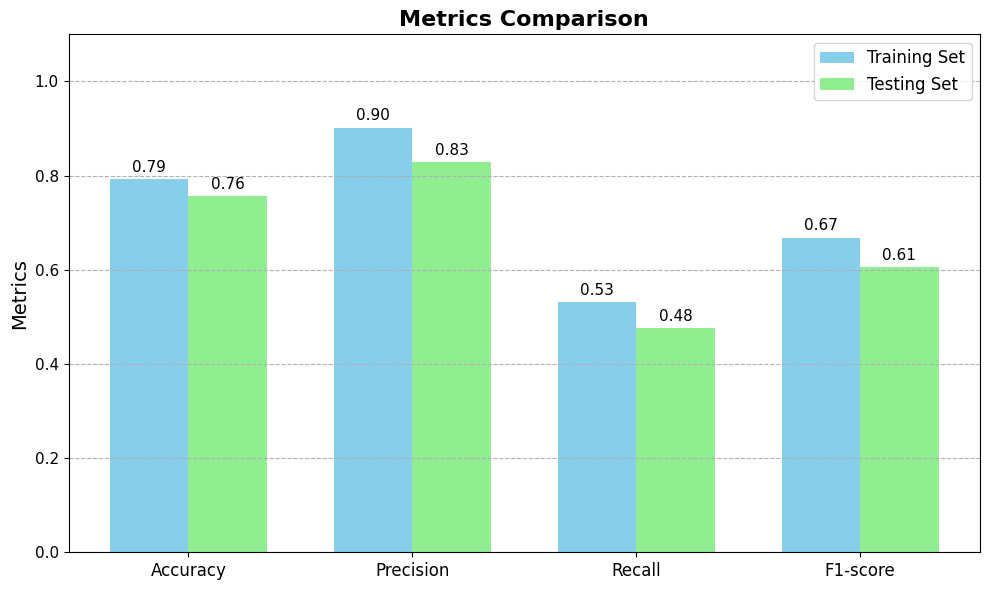

Độ chêch lệch giữa các giá trị metrics trên tập huấn luyện và tập kiểm tra: 
Accuracy: 0.0355
Precision: 0.0731
Recall: 0.0539
F1-Score: 0.0628


In [204]:
training_metrics = [best_knn_train_accuracy, best_knn_train_precision, best_knn_train_recall, best_knn_train_f1]
testing_metrics = [best_knn_accuracy, best_knn_precision, best_knn_recall, best_knn_f1]

compare_metrics(training_metrics, testing_metrics)
compute_metric_difference(training_metrics, testing_metrics)

#### Decision Tree

In [205]:
decisionTree_clf = DecisionTreeClassifier()

param_grid = {
    'max_depth': [2, 4, 6, 8], 
    'min_samples_split': [2, 4, 6, 8],
    'criterion': ['gini', 'entropy'] 
}

grid_search = GridSearchCV(decisionTree_clf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_params


{'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 6}

In [206]:
best_decisionTree_clf = grid_search.best_estimator_
y_test_pred = best_decisionTree_clf.predict(X_test)

best_decisionTree_accuracy = accuracy_score(y_test, y_test_pred)
best_decisionTree_precision = precision_score(y_test, y_test_pred)
best_decisionTree_recall = recall_score(y_test, y_test_pred)
best_decisionTree_f1 = f1_score(y_test, y_test_pred)

print_metrics(best_decisionTree_accuracy, best_decisionTree_precision, best_decisionTree_recall, best_decisionTree_f1)


Accuracy: 0.7627
Precision: 0.8019
Recall: 0.5231
F1-Score: 0.6331


In [207]:
y_train_pred = best_decisionTree_clf.predict(X_train)

best_decisionTree_train_accuracy = accuracy_score(y_train, y_train_pred)
best_decisionTree_train_precision = precision_score(y_train, y_train_pred)
best_decisionTree_train_recall = recall_score(y_train, y_train_pred)
best_decisionTree_train_f1 = f1_score(y_train, y_train_pred)

print_metrics(best_decisionTree_train_accuracy, best_decisionTree_train_precision, best_decisionTree_train_recall, best_decisionTree_train_f1)

Accuracy: 0.7885
Precision: 0.8583
Recall: 0.5557
F1-Score: 0.6746


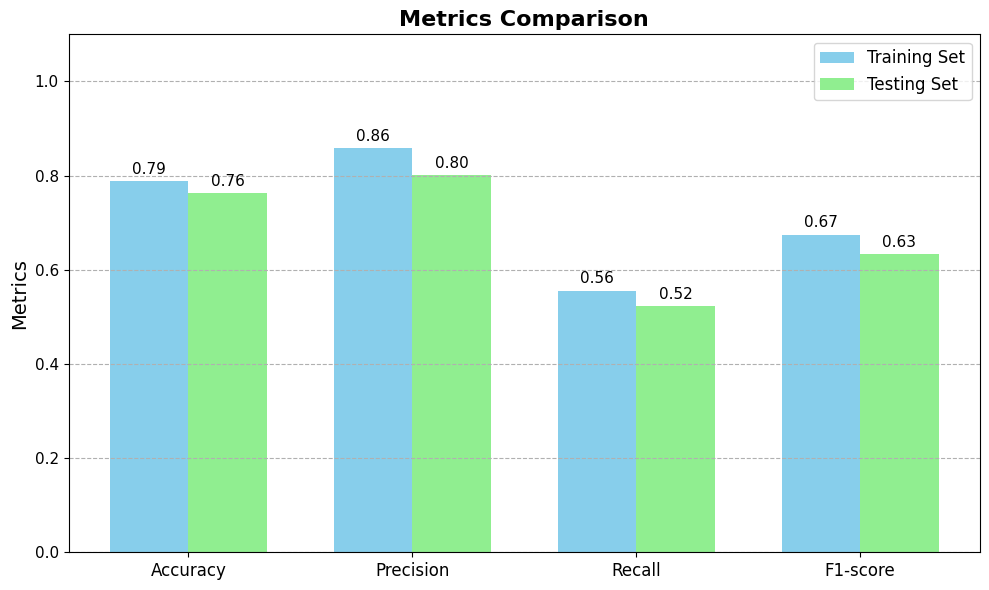

Độ chêch lệch giữa các giá trị metrics trên tập huấn luyện và tập kiểm tra: 
Accuracy: 0.0259
Precision: 0.0564
Recall: 0.0326
F1-Score: 0.0415


In [208]:
training_metrics = [best_decisionTree_train_accuracy, best_decisionTree_train_precision, best_decisionTree_train_recall, best_decisionTree_train_f1]
testing_metrics = [best_decisionTree_accuracy, best_decisionTree_precision, best_decisionTree_recall, best_decisionTree_f1]

compare_metrics(training_metrics, testing_metrics)
compute_metric_difference(training_metrics, testing_metrics)

#### Naive Bayes

In [209]:
nb_clf = GaussianNB()


#NB không có parameter nào hết
param_grid = {}

grid_search = GridSearchCV(nb_clf, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

best_nb_clf = grid_search.best_estimator_

best_nb_clf

GaussianNB()

In [210]:
y_test_pred = best_nb_clf.predict(X_test)

best_nb_accuracy = accuracy_score(y_test, y_test_pred)
best_nb_precision = precision_score(y_test, y_test_pred)
best_nb_recall = recall_score(y_test, y_test_pred)
best_nb_f1 = f1_score(y_test, y_test_pred)

print_metrics(best_nb_accuracy, best_nb_precision, best_nb_recall, best_nb_f1)


Accuracy: 0.7217
Precision: 0.8176
Recall: 0.3723
F1-Score: 0.5116


In [211]:
y_train_pred = best_nb_clf.predict(X_train)

best_nb_train_accuracy = accuracy_score(y_train, y_train_pred)
best_nb_train_precision = precision_score(y_train, y_train_pred)
best_nb_train_recall = recall_score(y_train, y_train_pred)
best_nb_train_f1 = f1_score(y_train, y_train_pred)

print_metrics(best_nb_train_accuracy, best_nb_train_precision, best_nb_train_recall, best_nb_train_f1)

Accuracy: 0.7358
Precision: 0.8539
Recall: 0.3984
F1-Score: 0.5433


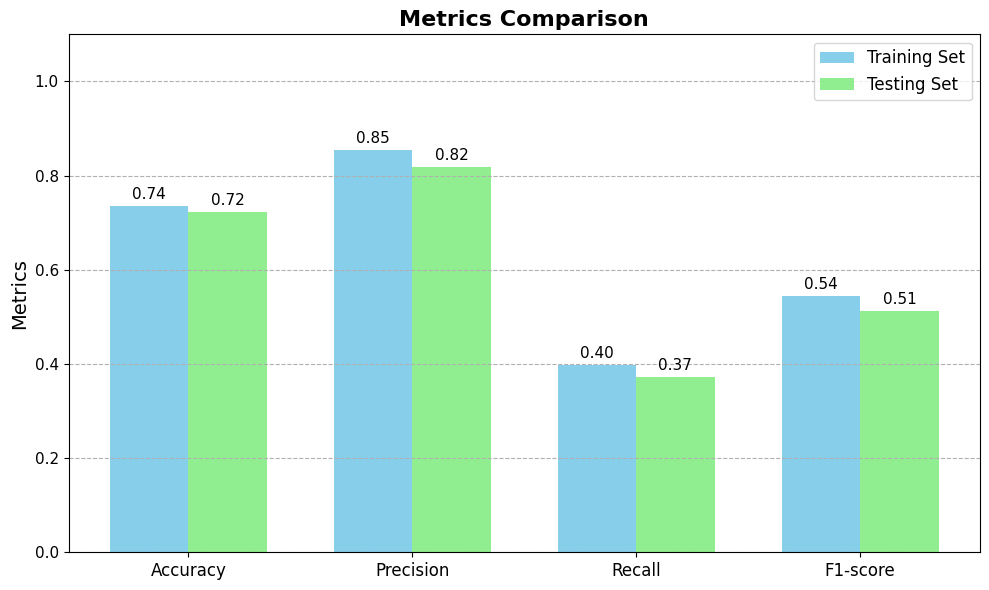

Độ chêch lệch giữa các giá trị metrics trên tập huấn luyện và tập kiểm tra: 
Accuracy: 0.0141
Precision: 0.0364
Recall: 0.0261
F1-Score: 0.0317


In [212]:
training_metrics = [best_nb_train_accuracy, best_nb_train_precision, best_nb_train_recall, best_nb_train_f1]
testing_metrics = [best_nb_accuracy, best_nb_precision, best_nb_recall, best_nb_f1]

compare_metrics(training_metrics, testing_metrics)
compute_metric_difference(training_metrics, testing_metrics)

#### SVM

In [213]:
svm_clf = LinearSVC()

param_grid = {
    'C': [0, 0.1, 1, 10, 100],
}

grid_search = GridSearchCV(svm_clf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_params


c:\Users\Thinh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\Thinh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\Thinh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\Thinh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of 

{'C': 1}

In [214]:
best_svm_clf = grid_search.best_estimator_
y_test_pred = best_svm_clf.predict(X_test)

best_svm_accuracy = accuracy_score(y_test, y_test_pred)
best_svm_precision = precision_score(y_test, y_test_pred)
best_svm_recall = recall_score(y_test, y_test_pred)
best_svm_f1 = f1_score(y_test, y_test_pred)

print_metrics(best_svm_accuracy, best_svm_precision, best_svm_recall, best_svm_f1)


Accuracy: 0.7301
Precision: 0.7149
Recall: 0.5169
F1-Score: 0.6000


In [215]:
y_train_pred = best_svm_clf.predict(X_train)

best_svm_train_accuracy = accuracy_score(y_train, y_train_pred)
best_svm_train_precision = precision_score(y_train, y_train_pred)
best_svm_train_recall = recall_score(y_train, y_train_pred)
best_svm_train_f1 = f1_score(y_train, y_train_pred)

print_metrics(best_svm_train_accuracy, best_svm_train_precision, best_svm_train_recall, best_svm_train_f1)

Accuracy: 0.7549
Precision: 0.7784
Recall: 0.5295
F1-Score: 0.6303


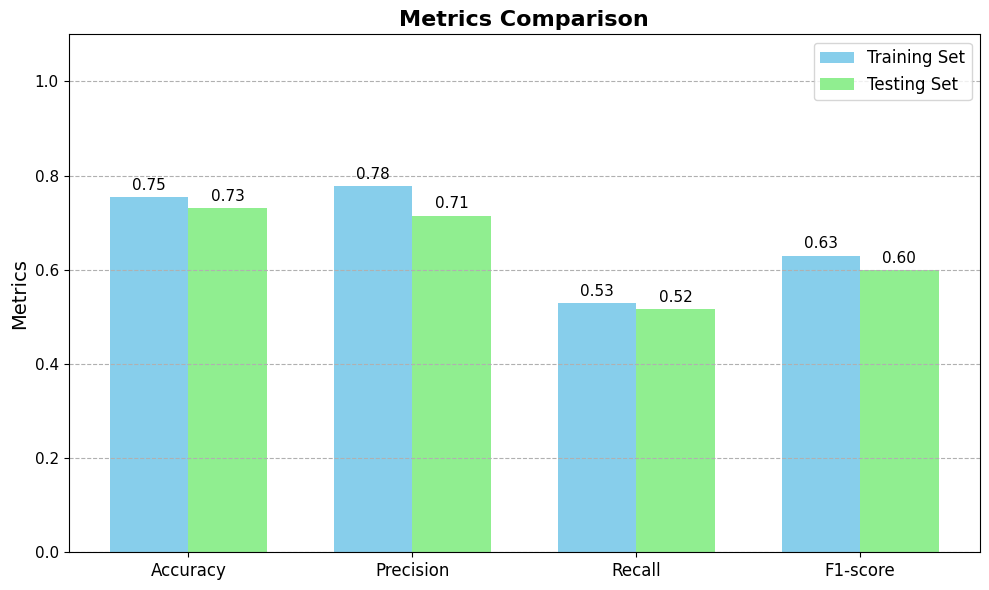

Độ chêch lệch giữa các giá trị metrics trên tập huấn luyện và tập kiểm tra: 
Accuracy: 0.0248
Precision: 0.0635
Recall: 0.0126
F1-Score: 0.0303


In [216]:
training_metrics = [best_svm_train_accuracy, best_svm_train_precision, best_svm_train_recall, best_svm_train_f1]
testing_metrics = [best_svm_accuracy, best_svm_precision, best_svm_recall, best_svm_f1]

compare_metrics(training_metrics, testing_metrics)
compute_metric_difference(training_metrics, testing_metrics)

#### Logistic Regression

In [217]:
logistic_Regression_clf = LinearSVC()

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}

grid_search = GridSearchCV(logistic_Regression_clf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_params


c:\Users\Thinh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\Thinh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\Thinh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\Thinh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of 

{'C': 0.01, 'penalty': 'l2'}

In [218]:
best_logistic_regression_clf = grid_search.best_estimator_
y_test_pred = best_logistic_regression_clf.predict(X_test)

best_logistic_regression_accuracy = accuracy_score(y_test, y_test_pred)
best_logistic_regression_precision = precision_score(y_test, y_test_pred)
best_logistic_regression_recall = recall_score(y_test, y_test_pred)
best_logistic_regression_f1 = f1_score(y_test, y_test_pred)

print_metrics(best_logistic_regression_accuracy, best_logistic_regression_precision, best_logistic_regression_recall, best_logistic_regression_f1)


Accuracy: 0.7313
Precision: 0.7179
Recall: 0.5169
F1-Score: 0.6011


In [219]:
y_train_pred = best_logistic_regression_clf.predict(X_train)

best_logistic_regression_train_accuracy = accuracy_score(y_train, y_train_pred)
best_logistic_regression_train_precision = precision_score(y_train, y_train_pred)
best_logistic_regression_train_recall = recall_score(y_train, y_train_pred)
best_logistic_regression_train_f1 = f1_score(y_train, y_train_pred)

print_metrics(best_logistic_regression_train_accuracy, best_logistic_regression_train_precision, best_logistic_regression_train_recall, best_logistic_regression_train_f1)

Accuracy: 0.7528
Precision: 0.7756
Recall: 0.5256
F1-Score: 0.6266


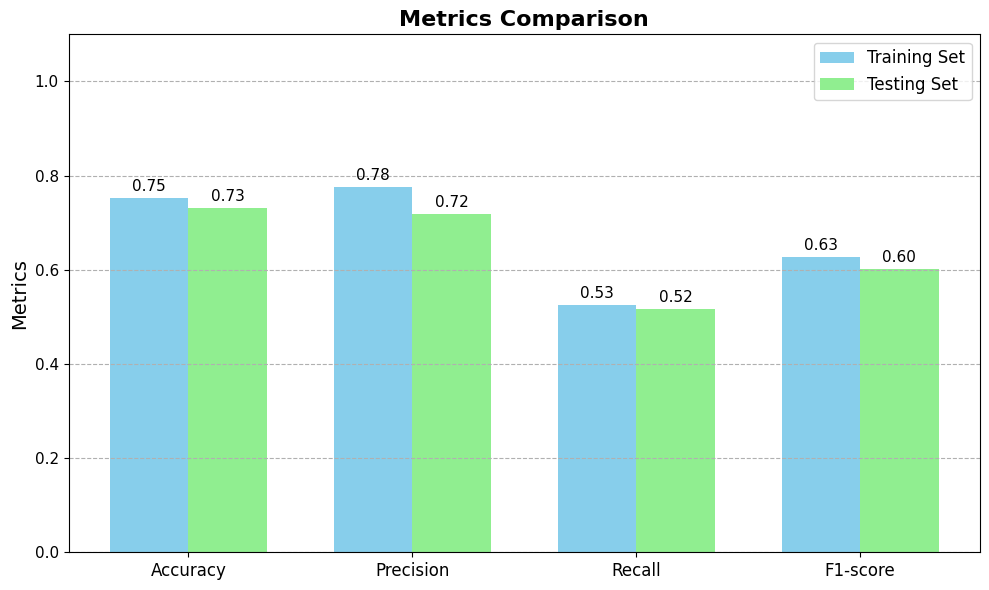

Độ chêch lệch giữa các giá trị metrics trên tập huấn luyện và tập kiểm tra: 
Accuracy: 0.0215
Precision: 0.0577
Recall: 0.0086
F1-Score: 0.0255


In [220]:
training_metrics = [best_logistic_regression_train_accuracy, best_logistic_regression_train_precision, best_logistic_regression_train_recall, best_logistic_regression_train_f1]
testing_metrics = [best_logistic_regression_accuracy, best_logistic_regression_precision, best_logistic_regression_recall, best_logistic_regression_f1]

compare_metrics(training_metrics, testing_metrics)
compute_metric_difference(training_metrics, testing_metrics)

### Các mô hình học máy thuộc Ensemble Learing

#### Gradient Boosting

 Sử dụng GridSearchCV, ta có thể tìm kiếm được bộ giá trị siêu tham số tốt nhất.

In [636]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200],
    'max_depth': [3, 7, 9]
}
gb_clf = GradientBoostingClassifier()
grid_search = GridSearchCV(estimator=gb_clf, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=5)
grid_search.fit(X_train, y_train)

#min_sample_split=125,  sub_sample=0.8

print("Bộ siêu tham số tốt nhất: ", grid_search.best_params_) 

Bộ siêu tham số tốt nhất:  {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}


In [639]:
gb_clf = GradientBoostingClassifier(max_depth=3, n_estimators=100, learning_rate=0.01)
#3, 200, 0.01
# 3 100 0.01
gb_clf.fit(X_train, y_train)

y_test_pred = gb_clf.predict(X_test) 

gb_accuracy = accuracy_score(y_test, y_test_pred)
gb_precision = precision_score(y_test, y_test_pred)
gb_recall = recall_score(y_test, y_test_pred)
gb_f1 = f1_score(y_test, y_test_pred)

print_metrics(gb_accuracy, gb_precision, gb_recall, gb_f1)

Accuracy: 0.7554
Precision: 0.9067
Recall: 0.4185
F1-Score: 0.5726


In [640]:
y_train_pred = gb_clf.predict(X_train)

gb_train_accuracy = accuracy_score(y_train, y_train_pred)
gb_train_precision = precision_score(y_train, y_train_pred)
gb_train_recall = recall_score(y_train, y_train_pred)
gb_train_f1 = f1_score(y_train, y_train_pred)

print_metrics(gb_train_accuracy, gb_train_precision, gb_train_recall, gb_train_f1)

Accuracy: 0.7523
Precision: 0.9011
Recall: 0.4181
F1-Score: 0.5712


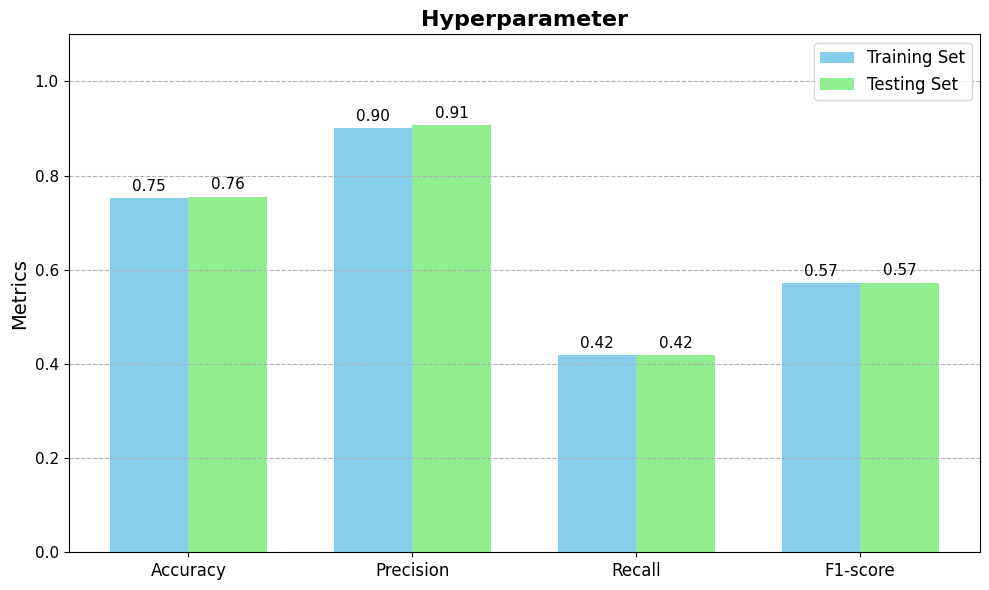

Độ chêch lệch giữa các giá trị metrics trên tập huấn luyện và tập kiểm tra: 
Accuracy: -0.0031
Precision: -0.0055
Recall: -0.0004
F1-Score: -0.0015


In [641]:
gb_training_metrics_after = [gb_train_accuracy, gb_train_precision, gb_train_recall, gb_train_f1]
gb_testing_metrics_after = [gb_accuracy, gb_precision, gb_recall, gb_f1]

compare_metrics(gb_training_metrics_after, gb_testing_metrics_after, title_2)
compute_metric_difference(gb_training_metrics_after, gb_testing_metrics_after)

##### Độ chênh lệch metrics trước khi sử dụng siêu tham số

In [642]:
compute_metric_difference(gb_training_metrics_before, gb_testing_metrics_before)

Độ chêch lệch giữa các giá trị metrics trên tập huấn luyện và tập kiểm tra: 
Accuracy: 0.0452
Precision: 0.0936
Recall: 0.0504
F1-Score: 0.0666


#### AdaBoost

In [643]:
param_grid = {
    'base_estimator': [DecisionTreeClassifier(max_depth=1, min_samples_split=2), DecisionTreeClassifier(max_depth=2, min_samples_split=4)],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.01]
}

grid_search = GridSearchCV(ada_clf, param_grid, cv=5)
grid_search.fit(X_train, y_train)
print("Bộ siêu tham số tốt nhất: ", grid_search.best_params_)

c:\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` w

Bộ siêu tham số tốt nhất:  {'base_estimator': DecisionTreeClassifier(max_depth=2, min_samples_split=4), 'learning_rate': 0.1, 'n_estimators': 100}


In [644]:
base_estimator = DecisionTreeClassifier(max_depth=2, min_samples_split=4)
ada_clf = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=100, learning_rate=0.1)

ada_clf.fit(X_train, y_train)
y_test_pred = ada_clf.predict(X_test)

ada_accuracy = accuracy_score(y_test, y_test_pred)
ada_precision = precision_score(y_test, y_test_pred)
ada_recall = recall_score(y_test, y_test_pred)
ada_f1 = f1_score(y_test, y_test_pred)

print_metrics(ada_accuracy, ada_precision, ada_recall, ada_f1)

Accuracy: 0.7602
Precision: 0.7972
Recall: 0.5200
F1-Score: 0.6294


c:\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


In [645]:
y_train_pred = ada_clf.predict(X_train)

ada_train_accuracy = accuracy_score(y_train, y_train_pred)
ada_train_precision = precision_score(y_train, y_train_pred)
ada_train_recall = recall_score(y_train, y_train_pred)
ada_train_f1 = f1_score(y_train, y_train_pred)

print_metrics(ada_train_accuracy, ada_train_precision, ada_train_recall, ada_train_f1)

Accuracy: 0.7828
Precision: 0.8507
Recall: 0.5452
F1-Score: 0.6645


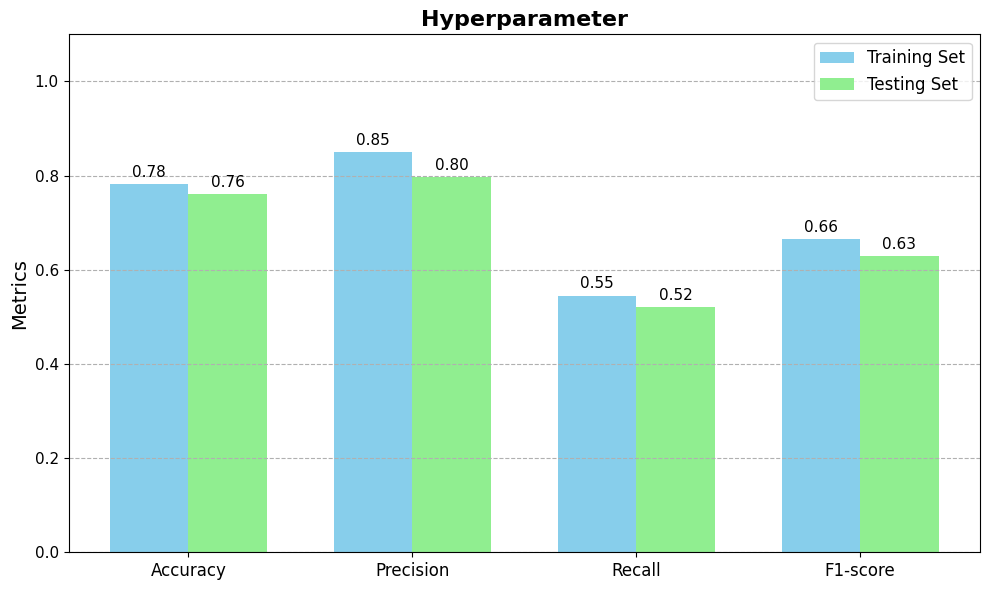

Độ chêch lệch giữa các giá trị metrics trên tập huấn luyện và tập kiểm tra: 
Accuracy: 0.0226
Precision: 0.0535
Recall: 0.0252
F1-Score: 0.0351


In [646]:
ada_training_metrics_after = [ada_train_accuracy, ada_train_precision, ada_train_recall, ada_train_f1]
ada_testing_metrics_after = [ada_accuracy, ada_precision, ada_recall, ada_f1]

compare_metrics(ada_training_metrics_after, ada_testing_metrics_after, title_2)
compute_metric_difference(ada_training_metrics_after, ada_testing_metrics_after)

##### Độ chênh lệch metrics trước khi sử dụng siêu tham số

In [681]:
compute_metric_difference(ada_training_metrics_before, ada_testing_metrics_before)

Độ chêch lệch giữa các giá trị metrics trên tập huấn luyện và tập kiểm tra: 
Accuracy: 0.046
Precision: 0.0894
Recall: 0.0502
F1-Score: 0.0655


#### Bagging

In [651]:
param_grid = {
    'base_estimator': [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=2), DecisionTreeClassifier(max_depth=3)],
    'n_estimators': [50, 100, 200],
    'max_samples': [0.5, 0.8],
    'max_features': [0.5, 0.8]
}

bagging = BaggingClassifier()
grid_search = GridSearchCV(bagging, param_grid, cv=5)
grid_search.fit(X_train, y_train)
print("Bộ siêu tham số tốt nhất: ", grid_search.best_params_)

c:\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` w

Bộ siêu tham số tốt nhất:  {'base_estimator': DecisionTreeClassifier(max_depth=3), 'max_features': 0.5, 'max_samples': 0.5, 'n_estimators': 100}


c:\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


In [656]:
base_estimator = DecisionTreeClassifier(max_depth=3)
bg_clf = BaggingClassifier(base_estimator=base_estimator, n_estimators=100, max_features=0.5, max_samples=0.5)

bg_clf.fit(X_train, y_train)
y_test_pred = bg_clf.predict(X_test)

bg_accuracy = accuracy_score(y_test, y_test_pred)
bg_precision = precision_score(y_test, y_test_pred)
bg_recall = recall_score(y_test, y_test_pred)
bg_f1 = f1_score(y_test, y_test_pred)

print_metrics(bg_accuracy, bg_precision, bg_recall, bg_f1)

Accuracy: 0.7446
Precision: 0.8897
Recall: 0.3969
F1-Score: 0.5489


c:\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


In [657]:
y_train_pred = bg_clf.predict(X_train)

bg_train_accuracy = accuracy_score(y_train, y_train_pred)
bg_train_precision = precision_score(y_train, y_train_pred)
bg_train_recall = recall_score(y_train, y_train_pred)
bg_train_f1 = f1_score(y_train, y_train_pred)

print_metrics(bg_train_accuracy, bg_train_precision, bg_train_recall, bg_train_f1)

Accuracy: 0.7549
Precision: 0.9025
Recall: 0.4246
F1-Score: 0.5775


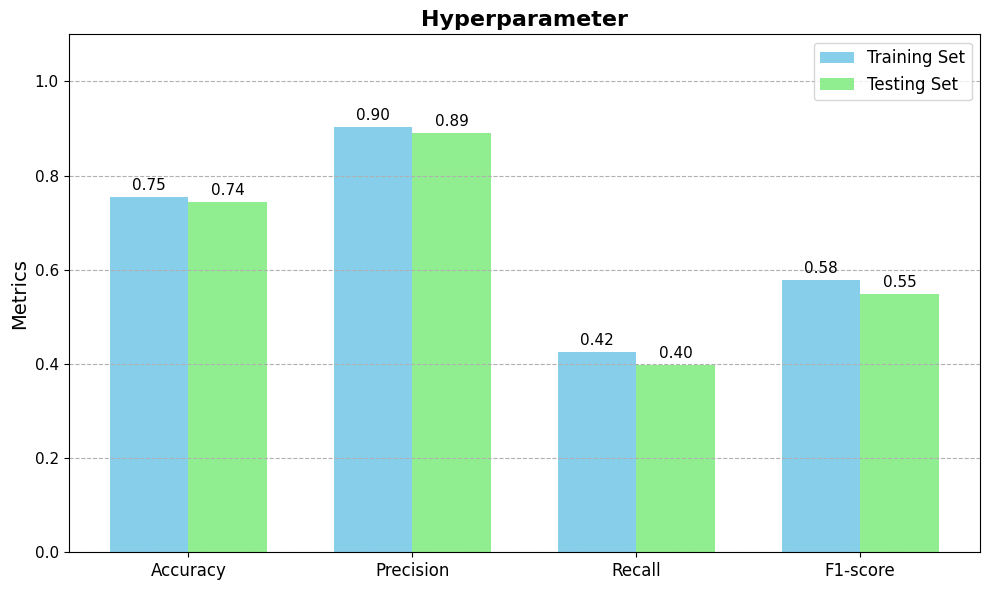

Độ chêch lệch giữa các giá trị metrics trên tập huấn luyện và tập kiểm tra: 
Accuracy: 0.0103
Precision: 0.0129
Recall: 0.0277
F1-Score: 0.0286


In [658]:
bg_training_metrics_after = [bg_train_accuracy, bg_train_precision, bg_train_recall, bg_train_f1]
bg_testing_metrics_after = [bg_accuracy, bg_precision, bg_recall, bg_f1]

compare_metrics(bg_training_metrics_after, bg_testing_metrics_after, title_2)
compute_metric_difference(bg_training_metrics_after, bg_testing_metrics_after)

##### Độ chênh lệch metrics trước khi sử dụng siêu tham số

In [682]:
compute_metric_difference(bg_training_metrics_before, bg_testing_metrics_before)

Độ chêch lệch giữa các giá trị metrics trên tập huấn luyện và tập kiểm tra: 
Accuracy: 0.2097
Precision: 0.2749
Recall: 0.2808
F1-Score: 0.2781


#### Random Forest

In [659]:
param_grid = {
    'n_estimators': [50, 75, 100, 200],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

random_forest = RandomForestClassifier()
grid_search = GridSearchCV(random_forest, param_grid, cv=5, n_jobs=5)
grid_search.fit(X_train, y_train)
print("Bộ siêu tham số tốt nhất: ", grid_search.best_params_)

Bộ siêu tham số tốt nhất:  {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 75}


In [664]:
rf_clf = RandomForestClassifier(max_depth=7, min_samples_split=2, min_samples_leaf=1, n_estimators=200)

rf_clf.fit(X_train, y_train)
y_test_pred = rf_clf.predict(X_test)

rf_accuracy = accuracy_score(y_test, y_test_pred)
rf_precision = precision_score(y_test, y_test_pred)
rf_recall = recall_score(y_test, y_test_pred)
rf_f1 = f1_score(y_test, y_test_pred)

print_metrics(rf_accuracy, rf_precision, rf_recall, rf_f1)

Accuracy: 0.7699
Precision: 0.8722
Recall: 0.4831
F1-Score: 0.6218


In [666]:
y_train_pred = rf_clf.predict(X_train)

rf_train_accuracy = accuracy_score(y_train, y_train_pred)
rf_train_precision = precision_score(y_train, y_train_pred)
rf_train_recall = recall_score(y_train, y_train_pred)
rf_train_f1 = f1_score(y_train, y_train_pred)

print_metrics(rf_train_accuracy, rf_train_precision, rf_train_recall, rf_train_f1)

Accuracy: 0.8056
Precision: 0.9428
Recall: 0.5400
F1-Score: 0.6867


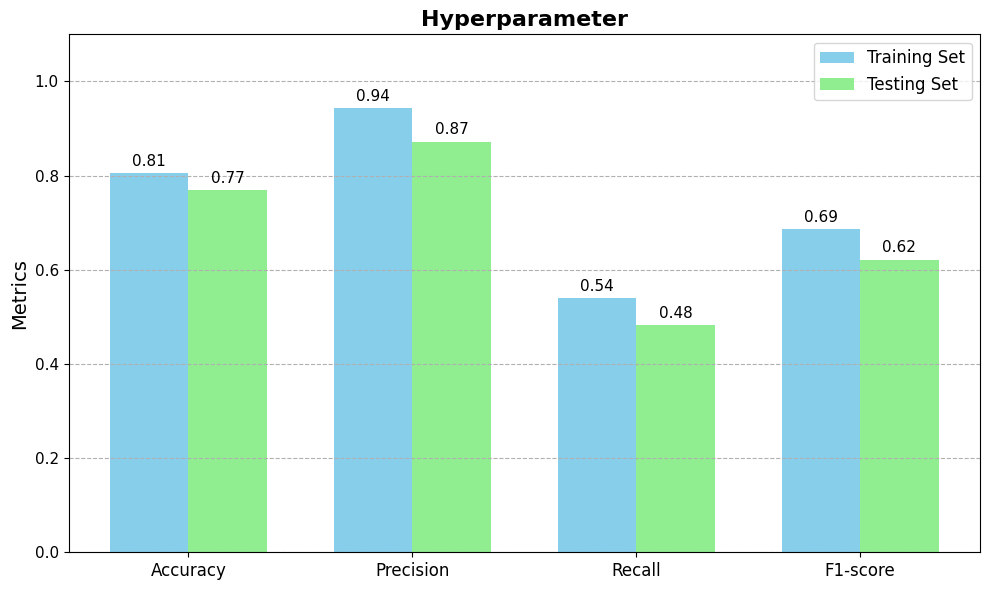

Độ chêch lệch giữa các giá trị metrics trên tập huấn luyện và tập kiểm tra: 
Accuracy: 0.0357
Precision: 0.0706
Recall: 0.0569
F1-Score: 0.0649


In [667]:
rf_training_metrics_after = [rf_train_accuracy, rf_train_precision, rf_train_recall, rf_train_f1]
rf_testing_metrics_after = [rf_accuracy, rf_precision, rf_recall, rf_f1]

compare_metrics(rf_training_metrics_after, rf_testing_metrics_after, title_2)
compute_metric_difference(rf_training_metrics_after, rf_testing_metrics_after)

##### Độ chênh lệch metrics trước khi sử dụng siêu tham số

In [683]:
compute_metric_difference(rf_training_metrics_before, rf_testing_metrics_before)

Độ chêch lệch giữa các giá trị metrics trên tập huấn luyện và tập kiểm tra: 
Accuracy: 0.2157
Precision: 0.2888
Recall: 0.2896
F1-Score: 0.2896


#### Voting Classifier

In [668]:
vt_clf = VotingClassifier(
    estimators=[('rf', rf_clf), ('gb', gb_clf), ('lr', lr_clf)]
)

param_grid = {
    'rf__n_estimators': [75, 100, 200, 300],
    'gb__learning_rate': [0.1, 0.01, 0.05, 0.001],
    'lr__C': [1, 5, 7, 10],
}

grid_search = GridSearchCV(estimator=vt_clf, param_grid=param_grid, cv=5, n_jobs=4)
grid_search.fit(X_train, y_train)

print("Bộ siêu tham số tốt nhất: ", grid_search.best_params_) 

Bộ siêu tham số tốt nhất:  {'gb__learning_rate': 0.1, 'lr__C': 1, 'rf__n_estimators': 300}


In [669]:
rf_clf = RandomForestClassifier(n_estimators=300, max_depth=3)
gb_clf = GradientBoostingClassifier(max_depth=3, n_estimators=75, learning_rate=0.1)
lr_clf = LogisticRegression(C=1)

vt_clf = VotingClassifier(
    estimators=[('rf', rf_clf), ('gb', gb_clf), ('lr', lr_clf)],
    voting='hard'
)

vt_clf.fit(X_train, y_train)
y_test_pred = vt_clf.predict(X_test)

vt_accuracy = accuracy_score(y_test, y_test_pred)
vt_precision = precision_score(y_test, y_test_pred)
vt_recall = recall_score(y_test, y_test_pred)
vt_f1 = f1_score(y_test, y_test_pred)

print_metrics(vt_accuracy, vt_precision, vt_recall, vt_f1)

Accuracy: 0.7530
Precision: 0.8125
Recall: 0.4800
F1-Score: 0.6035


In [670]:
y_train_pred = vt_clf.predict(X_train)

vt_train_accuracy = accuracy_score(y_train, y_train_pred)
vt_train_precision = precision_score(y_train, y_train_pred)
vt_train_recall = recall_score(y_train, y_train_pred)
vt_train_f1 = f1_score(y_train, y_train_pred)

print_metrics(vt_train_accuracy, vt_train_precision, vt_train_recall, vt_train_f1)

Accuracy: 0.7746
Precision: 0.8829
Recall: 0.4941
F1-Score: 0.6336


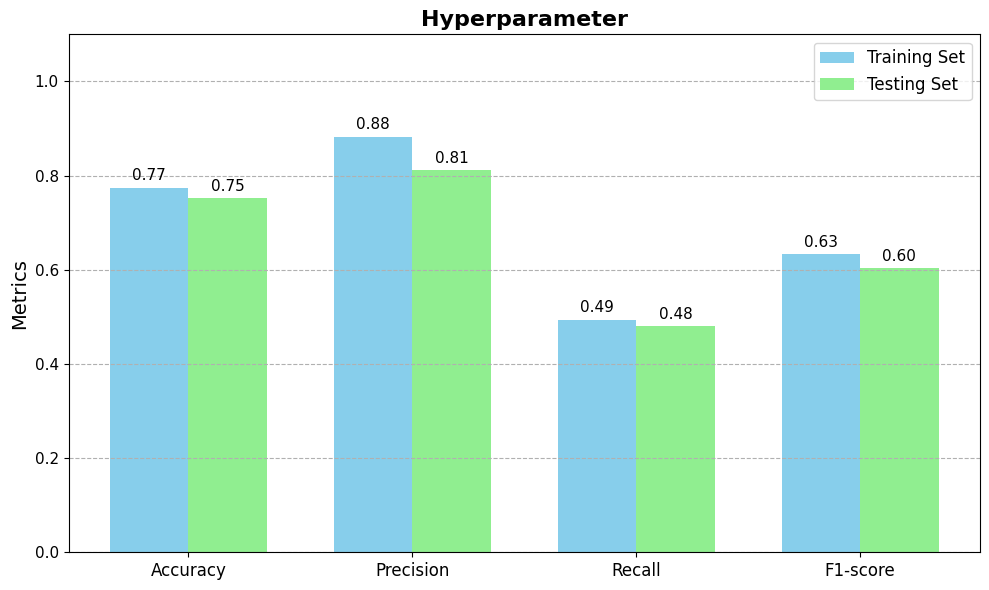

Độ chêch lệch giữa các giá trị metrics trên tập huấn luyện và tập kiểm tra: 
Accuracy: 0.0215
Precision: 0.0704
Recall: 0.0141
F1-Score: 0.0301


In [671]:
vt_training_metrics_after = [vt_train_accuracy, vt_train_precision, vt_train_recall, vt_train_f1]
vt_testing_metrics_after = [vt_accuracy, vt_precision, vt_recall, vt_f1]

compare_metrics(vt_training_metrics_after, vt_testing_metrics_after, title_2)
compute_metric_difference(vt_training_metrics_after, vt_testing_metrics_after)

##### Độ chênh lệch metrics trước khi sử dụng siêu tham số

In [672]:
compute_metric_difference(vt_training_metrics_before, vt_testing_metrics_before)

Độ chêch lệch giữa các giá trị metrics trên tập huấn luyện và tập kiểm tra: 
Accuracy: 0.0726
Precision: 0.1478
Recall: 0.0717
F1-Score: 0.1007


#### Stacking

In [673]:
rf_clf = RandomForestClassifier()
gb_clf = GradientBoostingClassifier()
lr_clf = LogisticRegression()

st_clf = StackingClassifier(
    estimators=[('rf', rf_clf), ('gb', gb_clf)],
    final_estimator=lr_clf
)

param_grid = {
    'rf__n_estimators': [100, 200, 300],
    'gb__learning_rate': [0.01, 0.05, 0.1],
    'final_estimator__C': [0.1, 1, 10],
}

grid_search = GridSearchCV(estimator=st_clf, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Bộ siêu tham số tốt nhất: ", grid_search.best_params_) 

Bộ siêu tham số tốt nhất:  {'final_estimator__C': 1, 'gb__learning_rate': 0.1, 'rf__n_estimators': 200}


In [674]:
base_models = [
    ('rf', RandomForestClassifier(n_estimators=100)),
    ('gb', GradientBoostingClassifier(learning_rate=0.1))
]

lr_clf = LogisticRegression(C=10)

st_clf = StackingClassifier(estimators=base_models, final_estimator=lr_clf)

st_clf.fit(X_train, y_train)

y_test_pred = st_clf.predict(X_test)

st_accuracy = accuracy_score(y_test, y_test_pred)
st_precision = precision_score(y_test, y_test_pred)
st_recall = recall_score(y_test, y_test_pred)
st_f1 = f1_score(y_test, y_test_pred)

print_metrics(st_accuracy, st_precision, st_recall, st_f1)

Accuracy: 0.7590
Precision: 0.7530
Recall: 0.5723
F1-Score: 0.6503


In [675]:
y_train_pred = st_clf.predict(X_train)

st_train_accuracy = accuracy_score(y_train, y_train_pred)
st_train_precision = precision_score(y_train, y_train_pred)
st_train_recall = recall_score(y_train, y_train_pred)
st_train_f1 = f1_score(y_train, y_train_pred)

print_metrics(st_train_accuracy, st_train_precision, st_train_recall, st_train_f1)

Accuracy: 0.7627
Precision: 0.7676
Recall: 0.5714
F1-Score: 0.6551


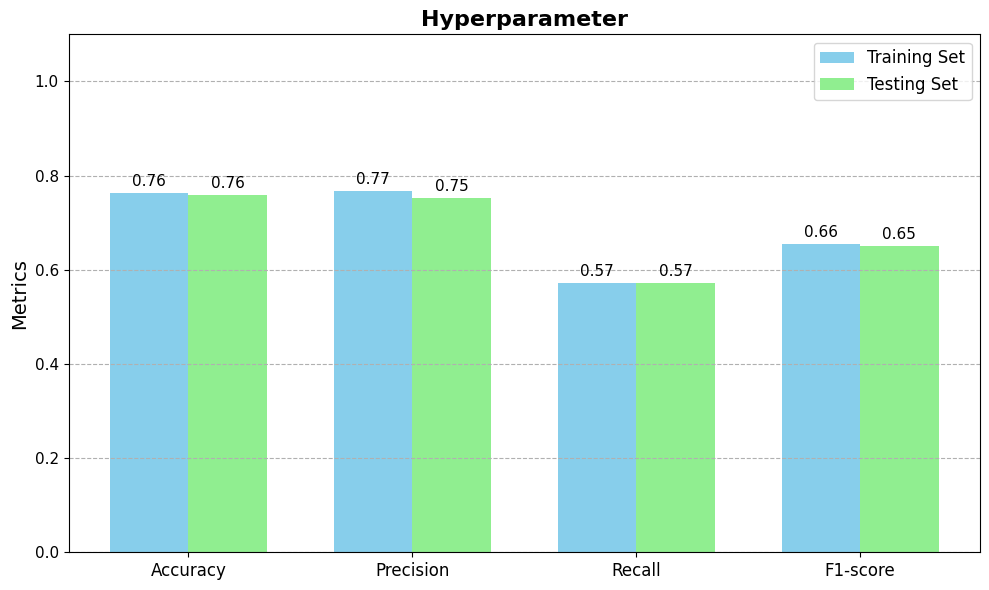

Độ chêch lệch giữa các giá trị metrics trên tập huấn luyện và tập kiểm tra: 
Accuracy: 0.0036
Precision: 0.0146
Recall: -0.0009
F1-Score: 0.0048


In [677]:
st_training_metrics_after = [st_train_accuracy, st_train_precision, st_train_recall, st_train_f1]
st_testing_metrics_after = [st_accuracy, st_precision, st_recall, st_f1]

compare_metrics(st_training_metrics_after, st_testing_metrics_after, title_2)
compute_metric_difference(st_training_metrics_after, st_testing_metrics_after)

##### Độ chênh lệch metrics trước khi sử dụng siêu tham số

In [684]:
compute_metric_difference(st_training_metrics_before, st_testing_metrics_before)

Độ chêch lệch giữa các giá trị metrics trên tập huấn luyện và tập kiểm tra: 
Accuracy: 0.0231
Precision: 0.0462
Recall: 0.0272
F1-Score: 0.0347


### Các mô hình neural network


#### Feed Forward Neural Network

- Với mô hình FFNN, em đã thay đổi áp dụng các phương thức Regularization L1L2, tăng thêm các lớp và số lượng Neural, dropout để giảm thiểu tình trạng Overfit cũng như tối ưu hiệu suất mô hình.
- Sau khi ứng dụng có thể thấy sự thay đổi đáng kể trong Accuracy

In [227]:
model_FFNW = tf.keras.Sequential([
    tf.keras.layers.Dense(64, kernel_initializer='uniform', activation='relu', kernel_regularizer=regularizers.L1L2(0.005)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(64, kernel_initializer='uniform', activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(64, kernel_initializer='uniform', activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(64, kernel_initializer='uniform', activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(64, kernel_initializer='uniform', activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(64, kernel_initializer='uniform', activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(1, kernel_initializer='uniform', activation='sigmoid')
])

model_FFNW.compile(loss="binary_crossentropy", metrics='accuracy', optimizer='adam')

history_FFNW_after = model_FFNW.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=32)

Epoch 1/100


61/61 [==============================] - 1s 6ms/step - loss: 0.7249 - accuracy: 0.6060 - val_loss: 0.6755 - val_accuracy: 0.6084
Epoch 2/100
61/61 [==============================] - 0s 3ms/step - loss: 0.6750 - accuracy: 0.6055 - val_loss: 0.6650 - val_accuracy: 0.6084
Epoch 3/100
61/61 [==============================] - 0s 3ms/step - loss: 0.6432 - accuracy: 0.6055 - val_loss: 0.6217 - val_accuracy: 0.6084
Epoch 4/100
61/61 [==============================] - 0s 3ms/step - loss: 0.6099 - accuracy: 0.6562 - val_loss: 0.6111 - val_accuracy: 0.7446
Epoch 5/100
61/61 [==============================] - 0s 3ms/step - loss: 0.6062 - accuracy: 0.7420 - val_loss: 0.5997 - val_accuracy: 0.7349
Epoch 6/100
61/61 [==============================] - 0s 3ms/step - loss: 0.5980 - accuracy: 0.7503 - val_loss: 0.5846 - val_accuracy: 0.7458
Epoch 7/100
61/61 [==============================] - 0s 3ms/step - loss: 0.5937 - accuracy: 0.7518 - val_loss: 0.5823 - val_accuracy: 0.7506
Epoch 8/100
61/61 [======

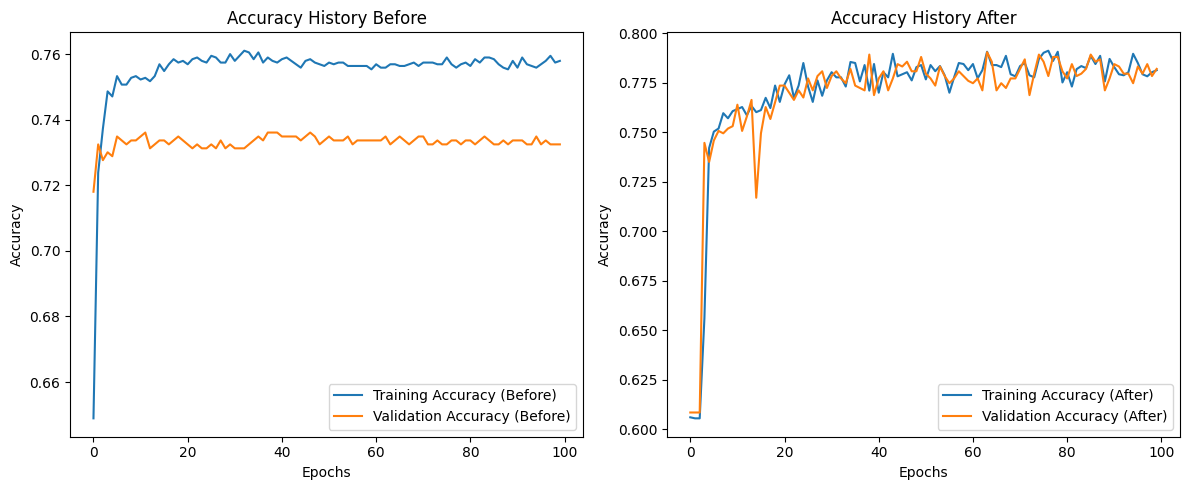

In [228]:
plot_accuracy_history_comparision(history_before=history_FFNW_before, history_after=history_FFNW_after)

#### Recurrent Neural Network

- Với mô hình FFNN, em đã thay đổi áp dụng các phương thức Regularization L1L2, tăng thêm các lớp và số lượng Neural, dropout để giảm thiểu tình trạng Overfit cũng như tối ưu hiệu suất mô hình.
- Sau khi ứng dụng có thể thấy sự thay đổi đáng kể trong Accuracy

Epoch 1/100
61/61 [==============================] - 3s 15ms/step - loss: 0.7832 - accuracy: 0.6034 - val_loss: 0.7622 - val_accuracy: 0.6084
Epoch 2/100
61/61 [==============================] - 1s 9ms/step - loss: 0.7408 - accuracy: 0.6169 - val_loss: 0.7254 - val_accuracy: 0.6084
Epoch 3/100
61/61 [==============================] - 1s 9ms/step - loss: 0.7048 - accuracy: 0.6365 - val_loss: 0.6841 - val_accuracy: 0.6386
Epoch 4/100
61/61 [==============================] - 1s 9ms/step - loss: 0.6567 - accuracy: 0.6923 - val_loss: 0.6301 - val_accuracy: 0.6988
Epoch 5/100
61/61 [==============================] - 1s 9ms/step - loss: 0.6330 - accuracy: 0.7037 - val_loss: 0.6011 - val_accuracy: 0.7434
Epoch 6/100
61/61 [==============================] - 1s 9ms/step - loss: 0.5981 - accuracy: 0.7218 - val_loss: 0.5691 - val_accuracy: 0.7446
Epoch 7/100
61/61 [==============================] - 1s 9ms/step - loss: 0.5897 - accuracy: 0.7347 - val_loss: 0.5599 - val_accuracy: 0.7482
Epoch 8/100


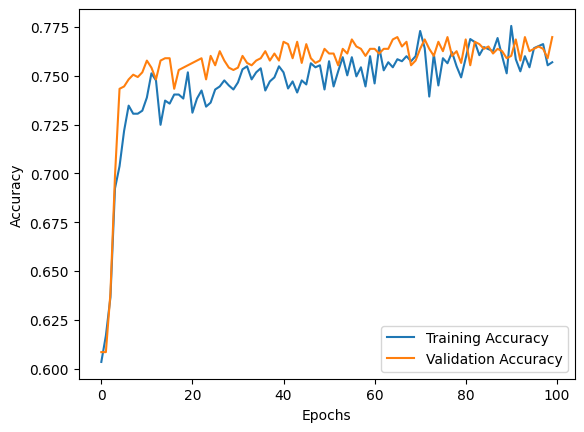

In [229]:

model_RNN = Sequential([
    tf.keras.layers.SimpleRNN(units = 32, activation='relu', return_sequences=True, input_shape= (X_train.shape[1],1), dropout=0.15, kernel_regularizer=regularizers.L1L2(0.02)),
    tf.keras.layers.LSTM(units = 32, activation='relu', return_sequences=True,  dropout=0.2),
    # tf.keras.layers.SimpleRNN(units = 32, activation='relu', return_sequences=True,  dropout=0.2),
    # tf.keras.layers.SimpleRNN(units = 32, activation='relu', return_sequences=True,  dropout=0.15),
    # tf.keras.layers.SimpleRNN(units = 32, activation='relu', return_sequences=True,  dropout=0.15),
    # tf.keras.layers.SimpleRNN(units = 16, activation='relu', return_sequences=True,  dropout=0.15),
    # tf.keras.layers.SimpleRNN(units = 16, activation='relu', return_sequences=True,  dropout=0.15),
    tf.keras.layers.SimpleRNN(units = 1, activation='sigmoid'),
])

model_RNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_RNN_after = model_RNN.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

plot_accuracy_history(history_RNN_after)


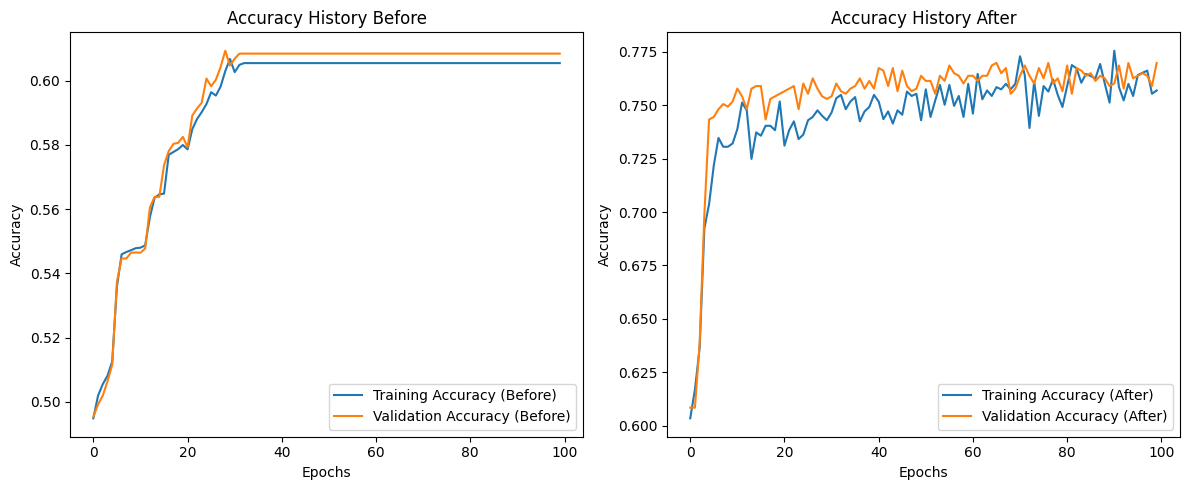

In [230]:
plot_accuracy_history_comparision(history_before=history_RNN_before, history_after=history_RNN_after)

## Phần 5: Sau khi huấn luyện xong mô hình thì muốn cải thiện độ chính xác, ta sẽ làm gì để giải quyết nó? Phân tích các trường hợp sai, đề ra giải pháp và thực hiện nó, sau đó đánh giá xem có cải tiến so với trước không. 

### Các mô hình cơ bản:

### Các mô hình Essembled

Sau khi huấn luyện các mô hình, em đã sử dụng GridSearchCV để tìm ra các hyperparameter (siêu tham số) phù hợp cho từng mô hình.

#### Gradient Boosting

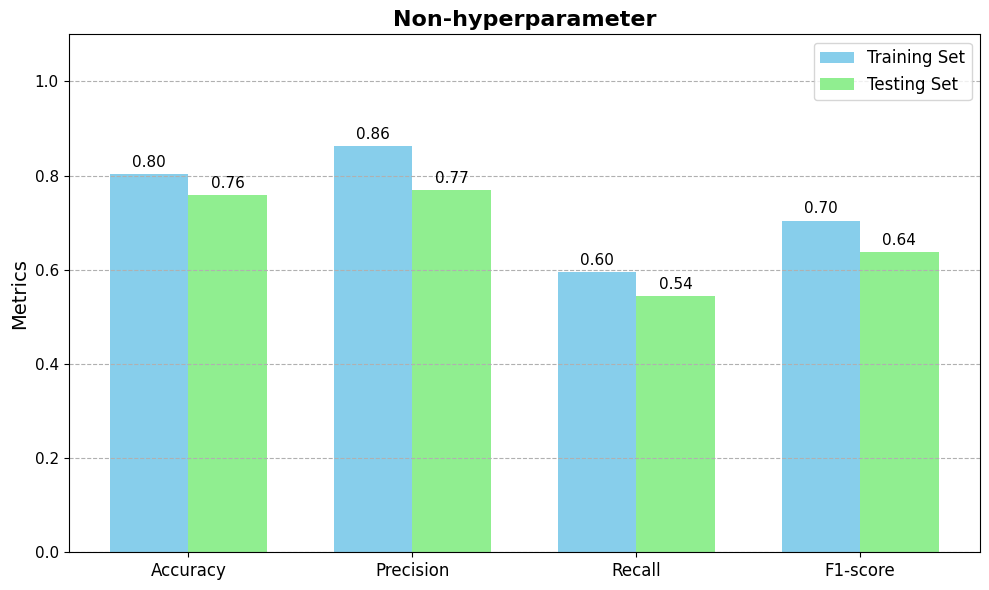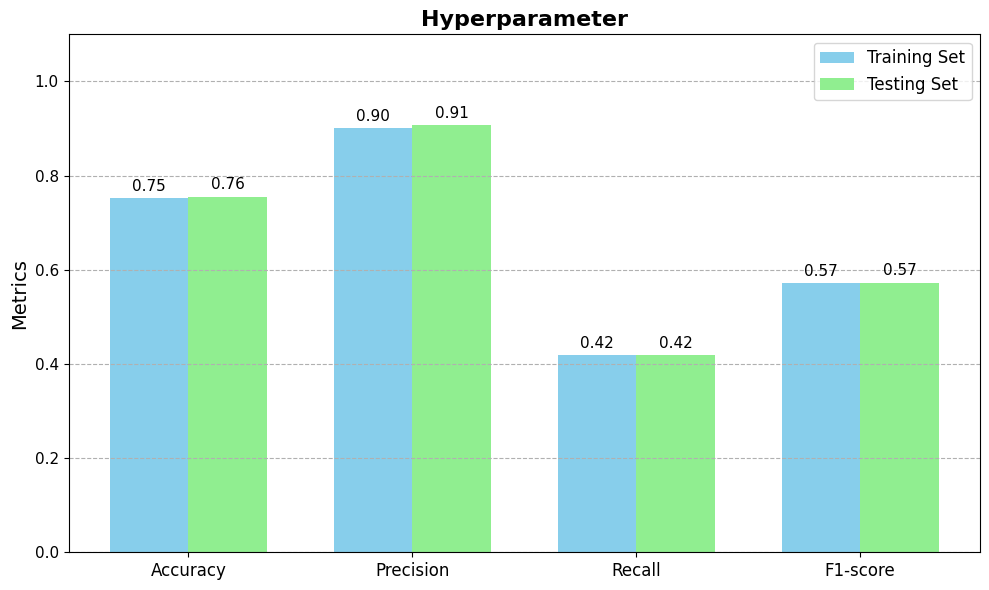

#### AdaBoost

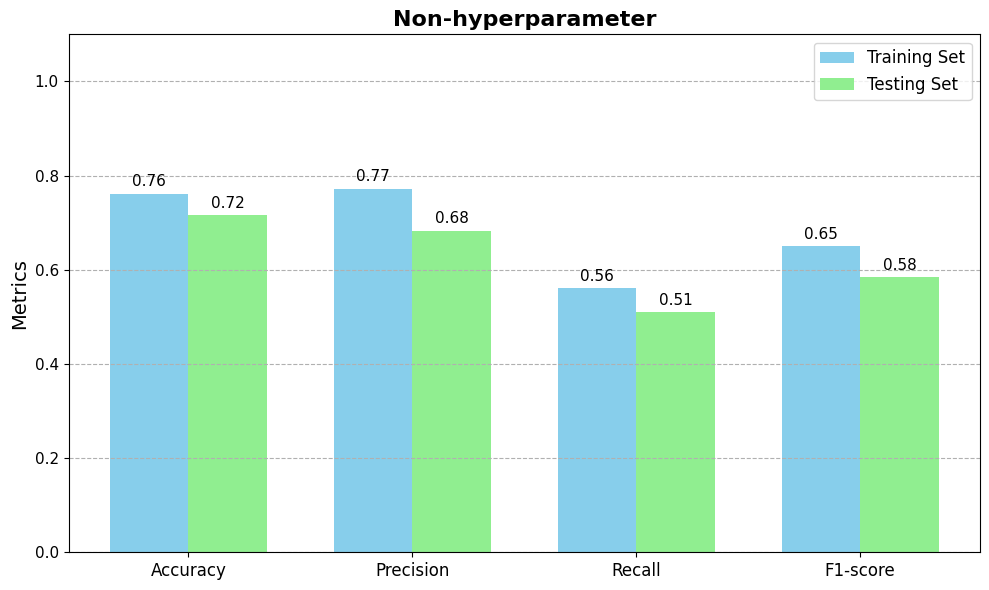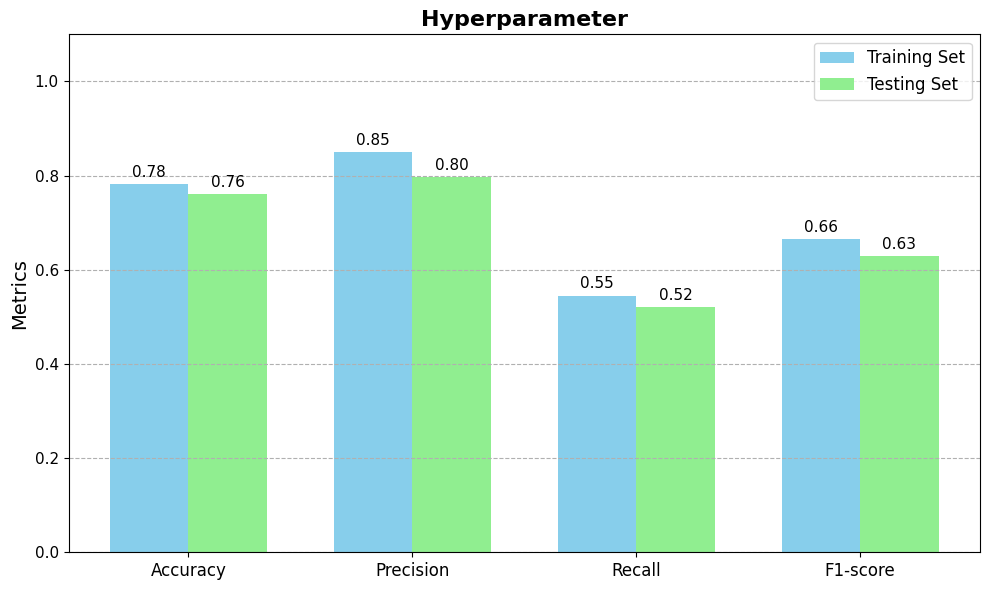

#### Bagging

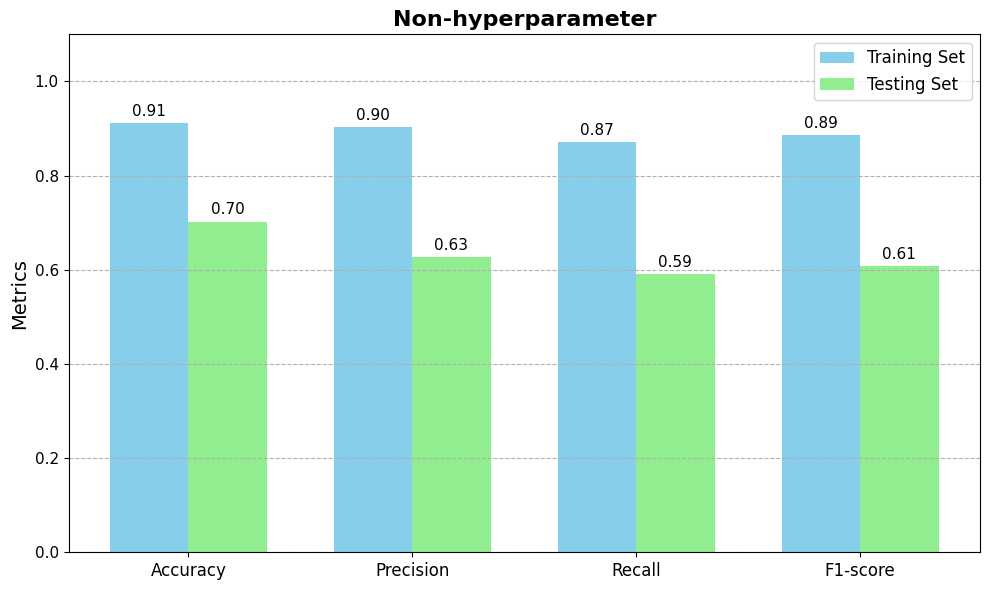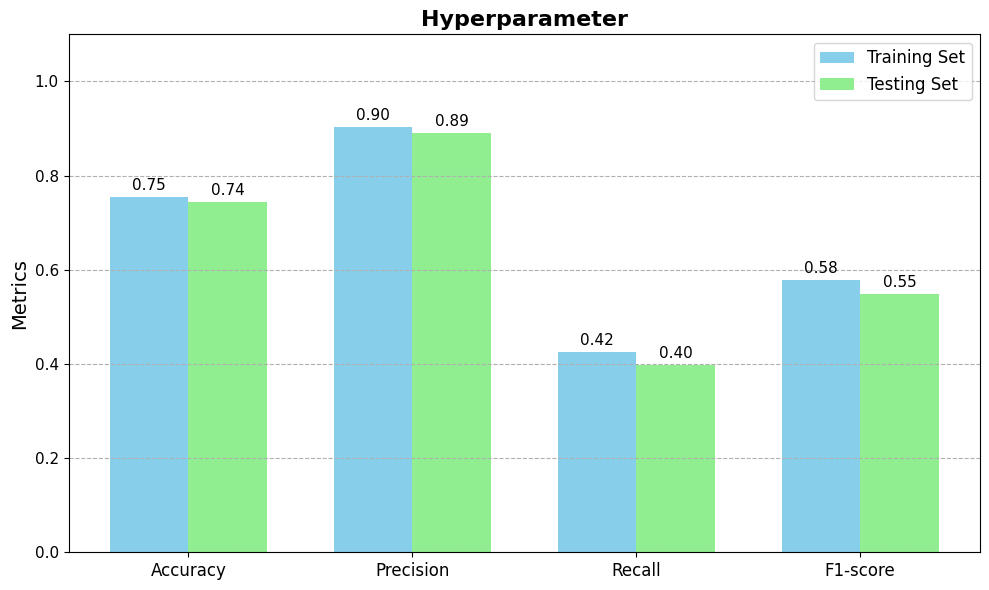

#### Random Forest

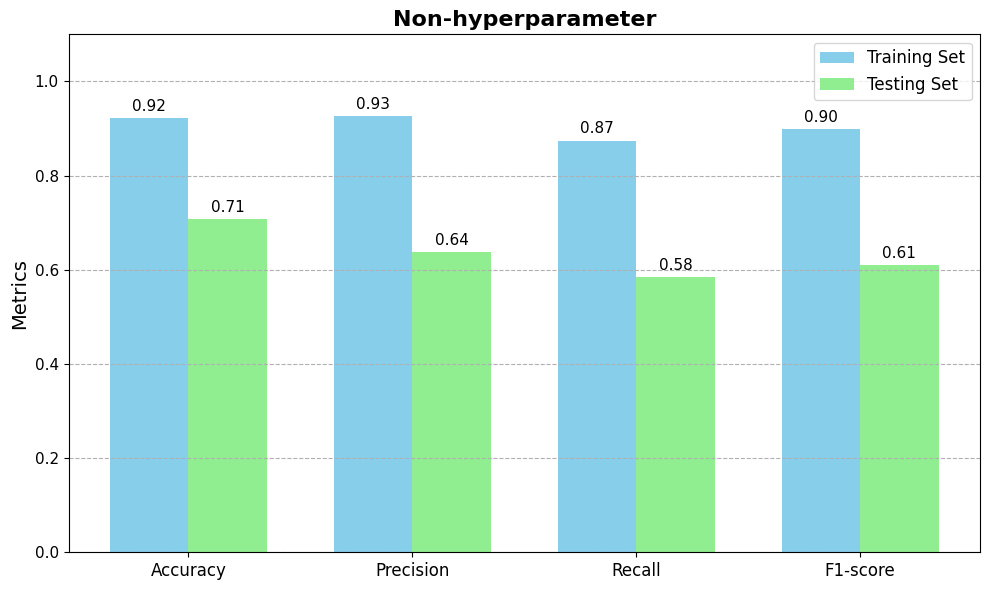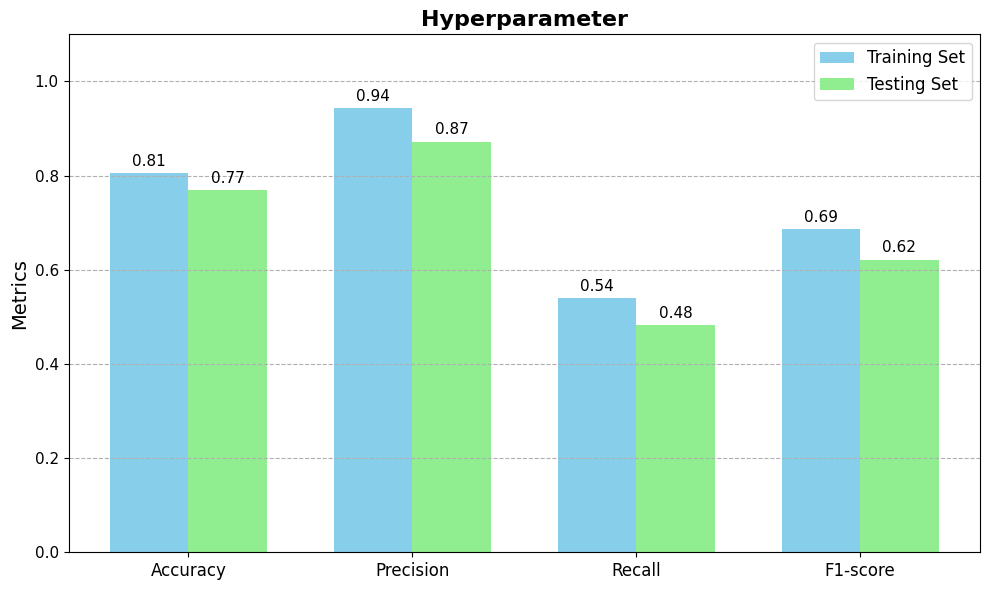

#### Voting 

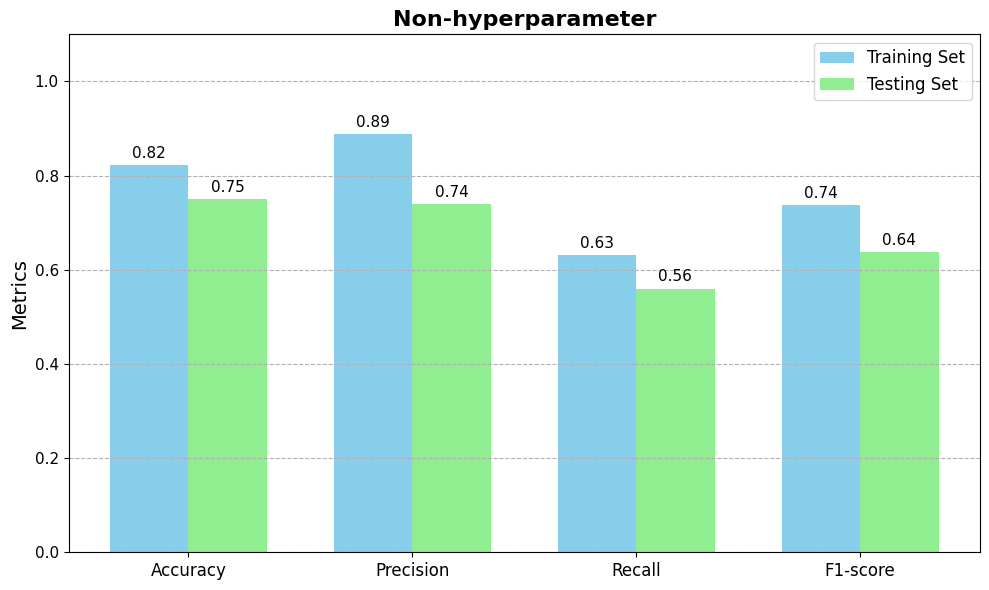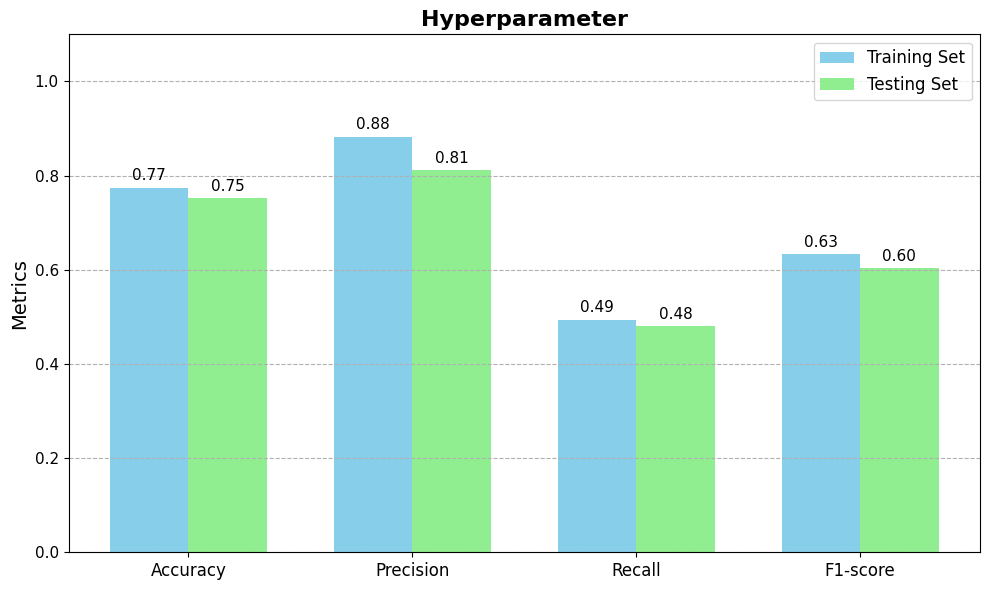

#### Stacking

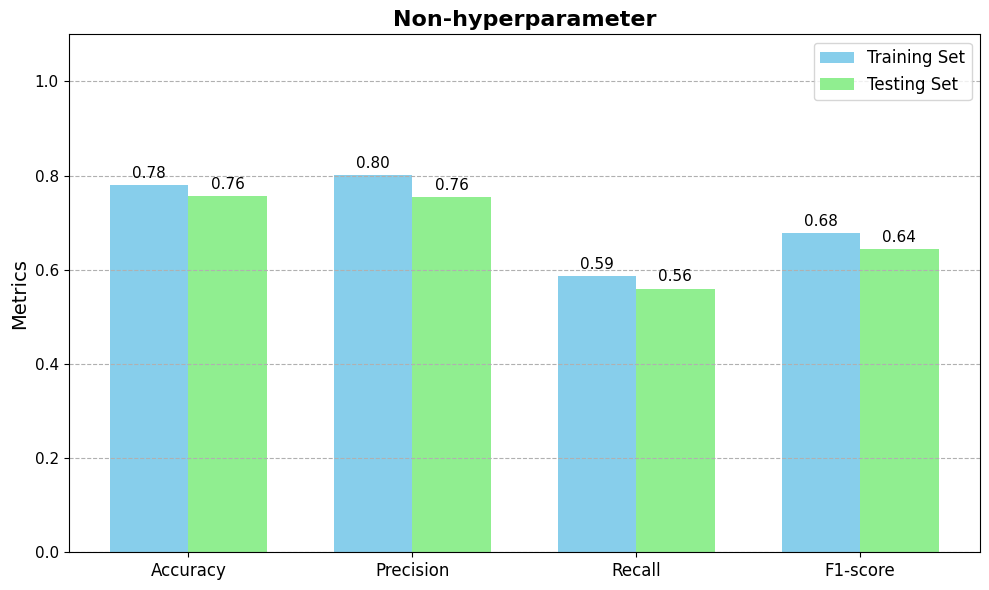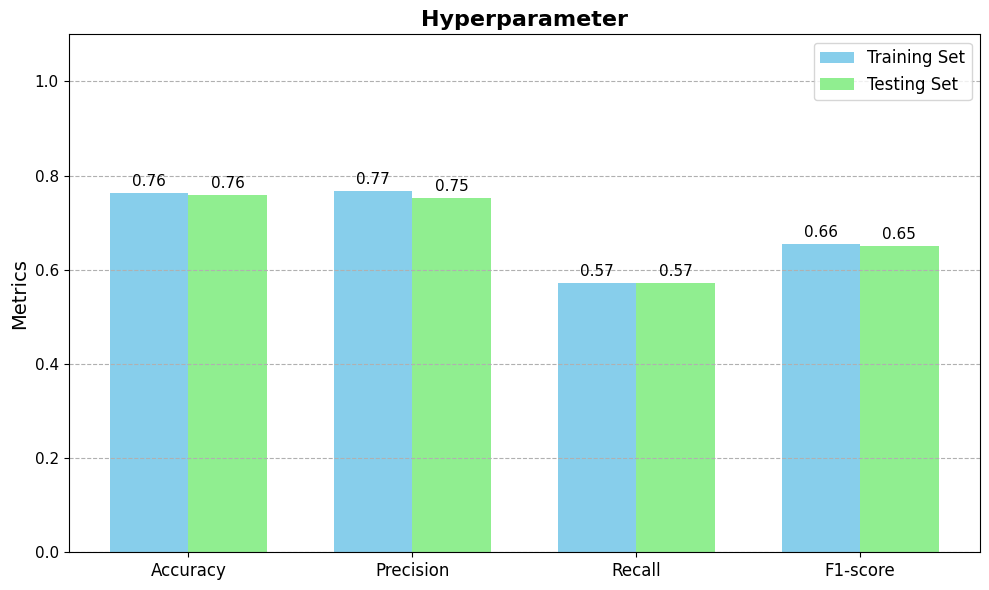

#### Đánh giá tổng quan

- Trước khi sử dụng các siêu tham số để huấn luyện mô hình (đối với những biểu đồ bên trái):

    - Ta dễ nhận thấy các giá trị testing metrics như accuracy, precision, recall và F1-Score thấp hơn so với giá trị training metrics, đó 'có thể' là dấu hiệu của hiện tượng overfitting nhưng, không thể nhận định rằng kết luận này hoàn toàn đúng. 
    - Thực tế, các giá trị testing metrics này thấp hơn giá trị training cũng có thể do mô hình chưa được điều chỉnh tối ưu để đạt hiệu suất tốt trên tập kiểm tra. Chính vì thế, em đã sử dụng các siêu tham số phù hợp để điều chỉnh lại các mô hình trên.

- Sau khi huấn luyện các mô hình với siêu tham số phù hợp (đối với những biểu đồ bên phải):

    - Độ chênh lệch giữa testing metrics và training metrics giảm đi đáng kể, điều này cho thấy mô hình đã học được cách tổng quát hóa tốt hơn cho dữ liệu mới cũng như hiệu suất tốt hơn trên tập kiểm tra.

    - Việc giảm chênh lệch giữa testing metrics và training metrics cũng cho thấy mô hình không bị ảnh hưởng quá nhiều bởi các biến động trong dữ liệu huấn luyện. Điều này làm giảm nguy cơ mô hình bị overfitting và tăng tính khả thi và tin cậy của mô hình khi áp dụng cho dữ liệu thực tế.

    - Bên cạnh đó, các giá trị recall và F1-score có xu hướng giảm đồng đều cho thấy các mô hình đã trở nên cân bằng hơn giữa việc tìm ra các mẫu true positive (recall) và độ chính xác (precision).

### Các mô hình Neural Network:

- Đầu tiên ta cần phải hiểu trong NN có 2 khái niệm khá quan trọng đó chính là Variance và Bias.
    - Variance chính là sai số accuracy giữa tập train và tập test: Variance = accuracy_train - accuracy_test
    - Bias mô tả khả năng học của mô hình, được tính: Bias = 1 - accuracy_test

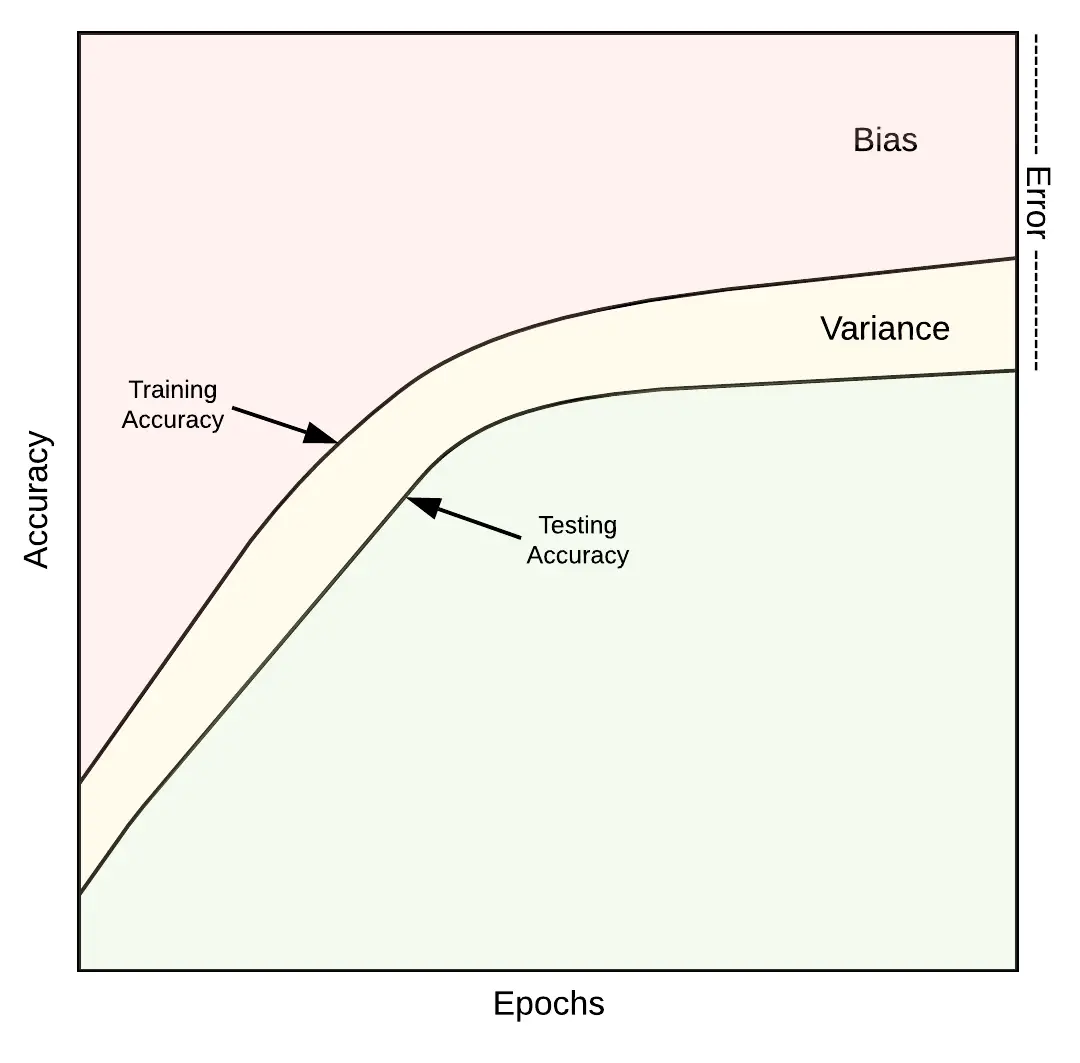

#### Với mô hình FFNN:

- Tại mô hình FFNN, dựa vào kết quả ban đầu thu được:

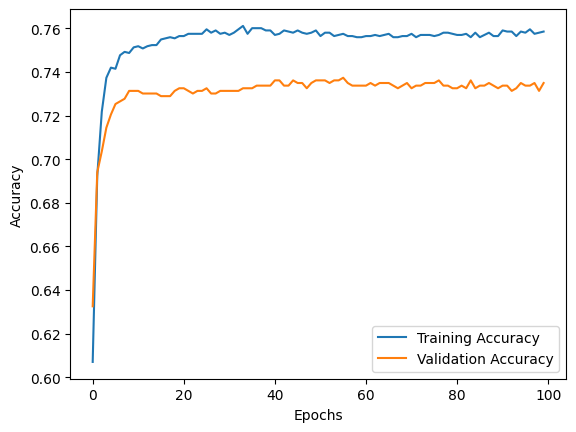

- Em đã xác định mình cần điều chỉnh bằng cách Giảm cả Bias và Variance để có thể tối ưu khả năng học của mô hình và tăng độ chính xác, do đó em đã thực hiện các bước sau: 
    - Increase model size => Giảm Bias (Tăng số lớp lẫn số node trong mỗi lớp).
    - Thêm Regularization => Giảm Variance (0.25)
    - Giảm Regularization => Giảm Bias (Giảm xuống còn 0.05)
    - Thay đổi các cấu trúc => Giảm Bias (Lựa chọn Optimizer, lựa chọn hàm activation Relu)
    - Sử dụng Feature Selection => Giảm Variance (Sử dụng Pearson Correlation để loại bỏ các Feature có Correlation trên 0.5)
- Và đây là kết quả sau thi thu lại được:

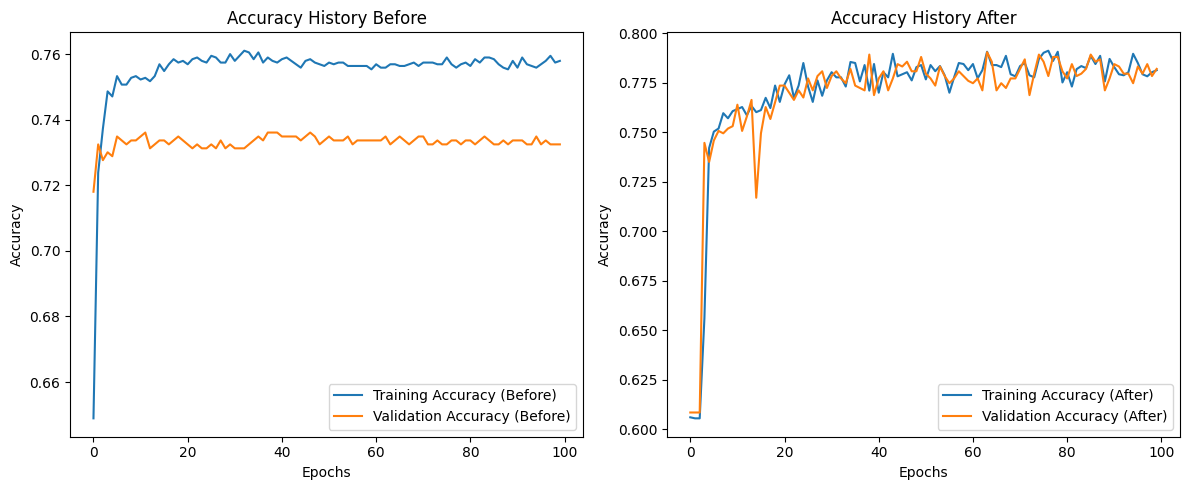

In [231]:
plot_accuracy_history_comparision(history_before=history_FFNW_before, history_after=history_FFNW_after)

- Có thể thấy Accuracy đã tăng lên đáng kể và sự sai lệch giữa Accuracy giữa tập train và tập test đã đồng bộ với nhau.

#### Với mô hình RNN:

- Kết quả thu được ban đầu của mô hình RNN:

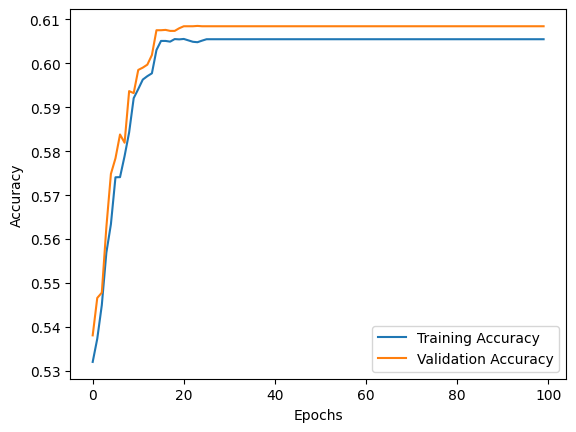  

- Dựa vào kết quả thu được ta có thể thấy cần phải giảm Bias, đây là cách thức em đã sử dụng:
    - Tăng kích thước của mô hình => Giảm Bias (Thêm nhiều lớp và điều chỉnh số Neural ở mỗi lớp)
    - Thay đổi cấu trức => Giảm Bias (Lựa chọn các hàm kích hoạt và Optimizer)
    - Thêm và điều chỉnh Regularization L1L2 => Cùng giảm Bias và Variance (lựa chọn 0.02)
- Sau cùng đây là kêt quả thu lại được, có thể thấy sự thay đổi đáng kể trong Accuracy

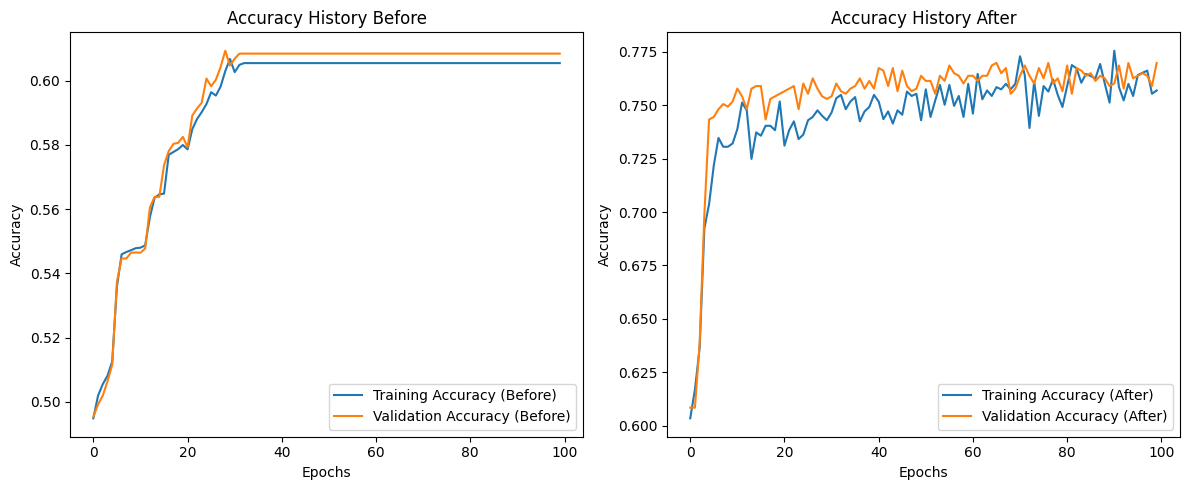

In [232]:
plot_accuracy_history_comparision(history_before=history_RNN_before, history_after=history_RNN_after)

- Accuracy sau khi áp dụng các phương pháp đã được cải thiện đáng kể, tuy nhiên vẫn chưa hoàn toàn giải quyết được tình trạng overfit triệt để do lượng data có giới hạn.